In [1]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_2.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
24136,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
24137,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
24138,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
24139,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
24140,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 24141/24141 [01:26<00:00, 279.89it/s]


In [4]:
# converting the list to numpy array
X = np.array(train_image,np.float16)
train_image=[]
# shape of the array
X.shape

(24141, 224, 224, 3)

In [5]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [6]:
X=[]
y=[]

In [7]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 224, 224, 3)
(4829, 224, 224, 3)
(19312, 51)
(4829, 51)


In [9]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [10]:
print(base_model.output_shape)

(None, None, None, 2048)


In [11]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv2_block3_out (Add)          (None, None, None, 2 0           max_pooling2d_1[0][0]            
                                                                 conv2_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_preact_bn (BatchNo (None, None, None, 2 1024        conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_preact_relu (Activ (None, None, None, 2 0           conv3_block1_preact_bn[0][0]     
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, None, None, 1 32768       conv3_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block3_2_relu (Activation (None, None, None, 2 0           conv4_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_out (Add)          (None, None, None, 1 0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_preact_relu (Activ (None, None, None, 1 0           conv4_block4_preact_bn[0][0]     
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block10_out (Add)         (None, None, None, 1 0           conv4_block9_out[0][0]           
                                                                 conv4_block10_3_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_preact_bn (BatchN (None, None, None, 1 4096        conv4_block10_out[0][0]          
__________________________________________________________________________________________________
conv4_block11_preact_relu (Acti (None, None, None, 1 0           conv4_block11_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block11_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block11_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

__________________________________________________________________________________________________
conv4_block18_preact_bn (BatchN (None, None, None, 1 4096        conv4_block17_out[0][0]          
__________________________________________________________________________________________________
conv4_block18_preact_relu (Acti (None, None, None, 1 0           conv4_block18_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block18_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block18_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_block18_1_bn (BatchNormal (None, None, None, 2 1024        conv4_block18_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block18_1_relu (Activatio (None, None, None, 2 0           conv4_block18_1_bn[0][0]         
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

                                                                 conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_preact_bn (BatchNo (None, None, None, 2 8192        conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_preact_relu (Activ (None, None, None, 2 0           conv5_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, None, None, 5 1048576     conv5_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [12]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(19312, 7*7*2048)

# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/ResNet101V2_X_train_2.pkl') 

t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

X_test = X_test.reshape(4829, 7*7*2048)

joblib.dump(X_test, '../Pickle/ResNet101V2_X_test_2.pkl')

In [13]:
# Load the model from the file 
X_train = joblib.load('../Pickle/ResNet101V2_X_train_2.pkl') 
X_test = joblib.load('../Pickle/ResNet101V2_X_test_2.pkl') 

In [14]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 100352)
(4829, 100352)
(19312, 51)
(4829, 51)


In [15]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [16]:
model.output_shape

(None, 51)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                52275     
Total params: 102,813,747
Trainable params: 102,813,747
Non-trainable params: 0
_________________________________________________________________


In [18]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [19]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])

In [20]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-12-06 01:39:19.778367
Train on 19312 samples, validate on 4829 samples
Epoch 1/100
19312/19312 [==============================] - ETA: 7:10 - loss: 8.2613 - accuracy: 0.03 - ETA: 4:44 - loss: 121.8340 - accuracy: 0.07 - ETA: 3:55 - loss: 157.3534 - accuracy: 0.07 - ETA: 3:30 - loss: 155.7363 - accuracy: 0.07 - ETA: 3:17 - loss: 150.7917 - accuracy: 0.07 - ETA: 3:08 - loss: 142.0922 - accuracy: 0.07 - ETA: 3:00 - loss: 130.6181 - accuracy: 0.08 - ETA: 2:53 - loss: 121.0694 - accuracy: 0.08 - ETA: 2:48 - loss: 111.8639 - accuracy: 0.09 - ETA: 2:45 - loss: 102.8757 - accuracy: 0.10 - ETA: 2:42 - loss: 95.3384 - accuracy: 0.1179 - ETA: 2:39 - loss: 88.4774 - accuracy: 0.131 - ETA: 2:37 - loss: 82.4197 - accuracy: 0.140 - ETA: 2:34 - loss: 77.0307 - accuracy: 0.146 - ETA: 2:31 - loss: 72.2770 - accuracy: 0.158 - ETA: 2:29 - loss: 68.1019 - accuracy: 0.170 - ETA: 2:26 - loss: 64.3274 - accuracy: 0.178 - ETA: 2:25 - loss: 60.9741 - accuracy: 0.182 - ETA: 2:23 - loss: 57.9688 - accuracy: 

19312/19312 [==============================] - ETA: 2:22 - loss: 2.1375 - accuracy: 0.49 - ETA: 2:23 - loss: 2.2202 - accuracy: 0.48 - ETA: 2:23 - loss: 2.2698 - accuracy: 0.47 - ETA: 2:21 - loss: 2.3906 - accuracy: 0.47 - ETA: 2:19 - loss: 2.4469 - accuracy: 0.46 - ETA: 2:18 - loss: 2.4833 - accuracy: 0.45 - ETA: 2:17 - loss: 2.5248 - accuracy: 0.47 - ETA: 2:17 - loss: 2.6043 - accuracy: 0.47 - ETA: 2:15 - loss: 2.5687 - accuracy: 0.47 - ETA: 2:15 - loss: 2.5449 - accuracy: 0.47 - ETA: 2:13 - loss: 2.5240 - accuracy: 0.47 - ETA: 2:12 - loss: 2.5289 - accuracy: 0.47 - ETA: 2:12 - loss: 2.5218 - accuracy: 0.47 - ETA: 2:11 - loss: 2.5244 - accuracy: 0.47 - ETA: 2:10 - loss: 2.5490 - accuracy: 0.47 - ETA: 2:08 - loss: 2.6068 - accuracy: 0.46 - ETA: 2:08 - loss: 2.6149 - accuracy: 0.46 - ETA: 2:07 - loss: 2.6100 - accuracy: 0.46 - ETA: 2:06 - loss: 2.5985 - accuracy: 0.46 - ETA: 2:06 - loss: 2.6044 - accuracy: 0.46 - ETA: 2:05 - loss: 2.5977 - accuracy: 0.46 - ETA: 2:04 - loss: 2.5858 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 2.0484 - accuracy: 0.58 - ETA: 2:26 - loss: 1.9747 - accuracy: 0.58 - ETA: 2:24 - loss: 1.9951 - accuracy: 0.57 - ETA: 2:25 - loss: 1.9560 - accuracy: 0.57 - ETA: 2:24 - loss: 1.9418 - accuracy: 0.58 - ETA: 2:23 - loss: 1.9347 - accuracy: 0.58 - ETA: 2:23 - loss: 2.0119 - accuracy: 0.58 - ETA: 2:23 - loss: 2.0295 - accuracy: 0.58 - ETA: 2:22 - loss: 1.9775 - accuracy: 0.58 - ETA: 2:21 - loss: 1.9568 - accuracy: 0.58 - ETA: 2:19 - loss: 1.9251 - accuracy: 0.59 - ETA: 2:18 - loss: 1.9291 - accuracy: 0.58 - ETA: 2:17 - loss: 1.9360 - accuracy: 0.58 - ETA: 2:15 - loss: 1.9522 - accuracy: 0.58 - ETA: 2:14 - loss: 1.9279 - accuracy: 0.59 - ETA: 2:13 - loss: 1.9149 - accuracy: 0.59 - ETA: 2:13 - loss: 1.9196 - accuracy: 0.58 - ETA: 2:12 - loss: 1.9290 - accuracy: 0.58 - ETA: 2:11 - loss: 1.9212 - accuracy: 0.58 - ETA: 2:10 - loss: 1.9210 - accuracy: 0.58 - ETA: 2:09 - loss: 1.9140 - accuracy: 0.58 - ETA: 2:08 - loss: 1.9060 - ac

19312/19312 [==============================] - ETA: 2:27 - loss: 1.8996 - accuracy: 0.64 - ETA: 2:22 - loss: 1.5974 - accuracy: 0.67 - ETA: 2:19 - loss: 1.7042 - accuracy: 0.65 - ETA: 2:17 - loss: 1.6799 - accuracy: 0.64 - ETA: 2:16 - loss: 1.6873 - accuracy: 0.64 - ETA: 2:15 - loss: 1.7113 - accuracy: 0.63 - ETA: 2:14 - loss: 1.7381 - accuracy: 0.63 - ETA: 2:13 - loss: 1.7089 - accuracy: 0.63 - ETA: 2:12 - loss: 1.7462 - accuracy: 0.63 - ETA: 2:10 - loss: 1.7545 - accuracy: 0.62 - ETA: 2:10 - loss: 1.7223 - accuracy: 0.63 - ETA: 2:09 - loss: 1.6887 - accuracy: 0.63 - ETA: 2:08 - loss: 1.6721 - accuracy: 0.63 - ETA: 2:07 - loss: 1.6888 - accuracy: 0.63 - ETA: 2:07 - loss: 1.7126 - accuracy: 0.63 - ETA: 2:07 - loss: 1.7130 - accuracy: 0.62 - ETA: 2:06 - loss: 1.7293 - accuracy: 0.62 - ETA: 2:05 - loss: 1.7314 - accuracy: 0.62 - ETA: 2:04 - loss: 1.7146 - accuracy: 0.62 - ETA: 2:03 - loss: 1.6995 - accuracy: 0.63 - ETA: 2:02 - loss: 1.7209 - accuracy: 0.62 - ETA: 2:01 - loss: 1.7491 - ac

19312/19312 [==============================] - ETA: 2:21 - loss: 1.8491 - accuracy: 0.60 - ETA: 2:22 - loss: 1.6488 - accuracy: 0.64 - ETA: 2:19 - loss: 1.6257 - accuracy: 0.66 - ETA: 2:18 - loss: 1.6503 - accuracy: 0.65 - ETA: 2:19 - loss: 1.6767 - accuracy: 0.65 - ETA: 2:17 - loss: 1.6513 - accuracy: 0.65 - ETA: 2:16 - loss: 1.6024 - accuracy: 0.65 - ETA: 2:16 - loss: 1.6182 - accuracy: 0.64 - ETA: 2:14 - loss: 1.6141 - accuracy: 0.64 - ETA: 2:14 - loss: 1.6295 - accuracy: 0.64 - ETA: 2:13 - loss: 1.6322 - accuracy: 0.64 - ETA: 2:12 - loss: 1.6076 - accuracy: 0.64 - ETA: 2:11 - loss: 1.6266 - accuracy: 0.64 - ETA: 2:10 - loss: 1.6008 - accuracy: 0.64 - ETA: 2:11 - loss: 1.6022 - accuracy: 0.64 - ETA: 2:11 - loss: 1.6243 - accuracy: 0.64 - ETA: 2:11 - loss: 1.6672 - accuracy: 0.64 - ETA: 2:11 - loss: 1.6753 - accuracy: 0.64 - ETA: 2:10 - loss: 1.6848 - accuracy: 0.64 - ETA: 2:10 - loss: 1.6656 - accuracy: 0.64 - ETA: 2:09 - loss: 1.6793 - accuracy: 0.64 - ETA: 2:09 - loss: 1.6867 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 1.7988 - accuracy: 0.60 - ETA: 2:21 - loss: 1.5396 - accuracy: 0.65 - ETA: 2:20 - loss: 1.5118 - accuracy: 0.66 - ETA: 2:19 - loss: 1.4023 - accuracy: 0.69 - ETA: 2:18 - loss: 1.4015 - accuracy: 0.70 - ETA: 2:18 - loss: 1.3853 - accuracy: 0.71 - ETA: 2:17 - loss: 1.3482 - accuracy: 0.70 - ETA: 2:16 - loss: 1.3382 - accuracy: 0.70 - ETA: 2:15 - loss: 1.3829 - accuracy: 0.70 - ETA: 2:14 - loss: 1.3931 - accuracy: 0.70 - ETA: 2:13 - loss: 1.4371 - accuracy: 0.69 - ETA: 2:13 - loss: 1.4399 - accuracy: 0.69 - ETA: 2:13 - loss: 1.4402 - accuracy: 0.69 - ETA: 2:11 - loss: 1.4731 - accuracy: 0.68 - ETA: 2:11 - loss: 1.4790 - accuracy: 0.68 - ETA: 2:10 - loss: 1.4720 - accuracy: 0.68 - ETA: 2:09 - loss: 1.4756 - accuracy: 0.68 - ETA: 2:08 - loss: 1.4686 - accuracy: 0.68 - ETA: 2:07 - loss: 1.4733 - accuracy: 0.68 - ETA: 2:06 - loss: 1.4913 - accuracy: 0.68 - ETA: 2:05 - loss: 1.5019 - accuracy: 0.67 - ETA: 2:04 - loss: 1.4927 - ac

19312/19312 [==============================] - ETA: 2:21 - loss: 1.4225 - accuracy: 0.69 - ETA: 2:20 - loss: 1.4734 - accuracy: 0.67 - ETA: 2:18 - loss: 1.4623 - accuracy: 0.69 - ETA: 2:17 - loss: 1.4298 - accuracy: 0.69 - ETA: 2:15 - loss: 1.5282 - accuracy: 0.67 - ETA: 2:15 - loss: 1.5593 - accuracy: 0.67 - ETA: 2:13 - loss: 1.5226 - accuracy: 0.67 - ETA: 2:12 - loss: 1.5183 - accuracy: 0.67 - ETA: 2:11 - loss: 1.4913 - accuracy: 0.68 - ETA: 2:11 - loss: 1.4684 - accuracy: 0.69 - ETA: 2:09 - loss: 1.4804 - accuracy: 0.68 - ETA: 2:09 - loss: 1.4869 - accuracy: 0.67 - ETA: 2:10 - loss: 1.4780 - accuracy: 0.68 - ETA: 2:09 - loss: 1.4629 - accuracy: 0.68 - ETA: 2:08 - loss: 1.4865 - accuracy: 0.68 - ETA: 2:07 - loss: 1.4770 - accuracy: 0.68 - ETA: 2:06 - loss: 1.4613 - accuracy: 0.68 - ETA: 2:05 - loss: 1.4799 - accuracy: 0.68 - ETA: 2:04 - loss: 1.4951 - accuracy: 0.68 - ETA: 2:03 - loss: 1.4998 - accuracy: 0.68 - ETA: 2:02 - loss: 1.4995 - accuracy: 0.68 - ETA: 2:02 - loss: 1.4994 - ac

19312/19312 [==============================] - ETA: 2:20 - loss: 1.5788 - accuracy: 0.68 - ETA: 2:17 - loss: 1.5138 - accuracy: 0.70 - ETA: 2:16 - loss: 1.2942 - accuracy: 0.73 - ETA: 2:15 - loss: 1.2935 - accuracy: 0.73 - ETA: 2:13 - loss: 1.2843 - accuracy: 0.73 - ETA: 2:11 - loss: 1.3037 - accuracy: 0.72 - ETA: 2:11 - loss: 1.3049 - accuracy: 0.71 - ETA: 2:09 - loss: 1.3232 - accuracy: 0.71 - ETA: 2:09 - loss: 1.3287 - accuracy: 0.71 - ETA: 2:08 - loss: 1.3178 - accuracy: 0.71 - ETA: 2:08 - loss: 1.3319 - accuracy: 0.71 - ETA: 2:09 - loss: 1.3142 - accuracy: 0.71 - ETA: 2:09 - loss: 1.3429 - accuracy: 0.71 - ETA: 2:08 - loss: 1.3240 - accuracy: 0.71 - ETA: 2:07 - loss: 1.3442 - accuracy: 0.71 - ETA: 2:06 - loss: 1.3419 - accuracy: 0.71 - ETA: 2:05 - loss: 1.3803 - accuracy: 0.71 - ETA: 2:04 - loss: 1.3704 - accuracy: 0.71 - ETA: 2:03 - loss: 1.3667 - accuracy: 0.71 - ETA: 2:03 - loss: 1.4112 - accuracy: 0.71 - ETA: 2:02 - loss: 1.4195 - accuracy: 0.71 - ETA: 2:01 - loss: 1.4247 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 1.5147 - accuracy: 0.71 - ETA: 2:20 - loss: 1.6107 - accuracy: 0.72 - ETA: 2:21 - loss: 1.4947 - accuracy: 0.72 - ETA: 2:21 - loss: 1.3873 - accuracy: 0.72 - ETA: 2:20 - loss: 1.3327 - accuracy: 0.72 - ETA: 2:19 - loss: 1.2922 - accuracy: 0.72 - ETA: 2:19 - loss: 1.3265 - accuracy: 0.72 - ETA: 2:19 - loss: 1.3062 - accuracy: 0.72 - ETA: 2:18 - loss: 1.3082 - accuracy: 0.72 - ETA: 2:16 - loss: 1.2773 - accuracy: 0.72 - ETA: 2:15 - loss: 1.3034 - accuracy: 0.73 - ETA: 2:14 - loss: 1.3313 - accuracy: 0.72 - ETA: 2:12 - loss: 1.3531 - accuracy: 0.72 - ETA: 2:11 - loss: 1.3266 - accuracy: 0.72 - ETA: 2:10 - loss: 1.3124 - accuracy: 0.72 - ETA: 2:09 - loss: 1.3188 - accuracy: 0.72 - ETA: 2:08 - loss: 1.3030 - accuracy: 0.73 - ETA: 2:08 - loss: 1.2989 - accuracy: 0.72 - ETA: 2:07 - loss: 1.2819 - accuracy: 0.73 - ETA: 2:06 - loss: 1.2692 - accuracy: 0.73 - ETA: 2:05 - loss: 1.2864 - accuracy: 0.72 - ETA: 2:03 - loss: 1.2940 - ac

19312/19312 [==============================] - ETA: 2:27 - loss: 1.4871 - accuracy: 0.67 - ETA: 2:24 - loss: 1.2001 - accuracy: 0.72 - ETA: 2:23 - loss: 1.1687 - accuracy: 0.72 - ETA: 2:23 - loss: 1.2510 - accuracy: 0.71 - ETA: 2:21 - loss: 1.2901 - accuracy: 0.72 - ETA: 2:20 - loss: 1.2409 - accuracy: 0.73 - ETA: 2:20 - loss: 1.2201 - accuracy: 0.73 - ETA: 2:18 - loss: 1.2246 - accuracy: 0.73 - ETA: 2:17 - loss: 1.2051 - accuracy: 0.73 - ETA: 2:18 - loss: 1.2065 - accuracy: 0.73 - ETA: 2:17 - loss: 1.2232 - accuracy: 0.73 - ETA: 2:16 - loss: 1.2244 - accuracy: 0.72 - ETA: 2:14 - loss: 1.2335 - accuracy: 0.73 - ETA: 2:13 - loss: 1.2287 - accuracy: 0.73 - ETA: 2:11 - loss: 1.2148 - accuracy: 0.73 - ETA: 2:10 - loss: 1.2114 - accuracy: 0.73 - ETA: 2:09 - loss: 1.2227 - accuracy: 0.73 - ETA: 2:08 - loss: 1.2264 - accuracy: 0.73 - ETA: 2:07 - loss: 1.2486 - accuracy: 0.73 - ETA: 2:06 - loss: 1.2613 - accuracy: 0.72 - ETA: 2:04 - loss: 1.2529 - accuracy: 0.73 - ETA: 2:03 - loss: 1.2462 - ac

19312/19312 [==============================] - ETA: 2:34 - loss: 1.5684 - accuracy: 0.72 - ETA: 2:28 - loss: 1.7265 - accuracy: 0.75 - ETA: 2:26 - loss: 1.6370 - accuracy: 0.74 - ETA: 2:23 - loss: 1.5168 - accuracy: 0.73 - ETA: 2:21 - loss: 1.4083 - accuracy: 0.75 - ETA: 2:20 - loss: 1.3991 - accuracy: 0.74 - ETA: 2:19 - loss: 1.3742 - accuracy: 0.74 - ETA: 2:19 - loss: 1.3315 - accuracy: 0.74 - ETA: 2:18 - loss: 1.3271 - accuracy: 0.74 - ETA: 2:16 - loss: 1.2914 - accuracy: 0.74 - ETA: 2:15 - loss: 1.2657 - accuracy: 0.74 - ETA: 2:15 - loss: 1.2524 - accuracy: 0.74 - ETA: 2:15 - loss: 1.2415 - accuracy: 0.74 - ETA: 2:15 - loss: 1.2405 - accuracy: 0.74 - ETA: 2:14 - loss: 1.2223 - accuracy: 0.74 - ETA: 2:13 - loss: 1.2162 - accuracy: 0.74 - ETA: 2:12 - loss: 1.2242 - accuracy: 0.74 - ETA: 2:10 - loss: 1.2222 - accuracy: 0.74 - ETA: 2:09 - loss: 1.2406 - accuracy: 0.74 - ETA: 2:08 - loss: 1.2602 - accuracy: 0.73 - ETA: 2:06 - loss: 1.2624 - accuracy: 0.74 - ETA: 2:05 - loss: 1.2548 - ac

19312/19312 [==============================] - ETA: 2:42 - loss: 1.0343 - accuracy: 0.74 - ETA: 2:31 - loss: 1.1071 - accuracy: 0.75 - ETA: 2:28 - loss: 1.1205 - accuracy: 0.75 - ETA: 2:24 - loss: 1.1077 - accuracy: 0.75 - ETA: 2:23 - loss: 1.1614 - accuracy: 0.75 - ETA: 2:21 - loss: 1.3215 - accuracy: 0.74 - ETA: 2:19 - loss: 1.2712 - accuracy: 0.75 - ETA: 2:17 - loss: 1.3179 - accuracy: 0.74 - ETA: 2:18 - loss: 1.3206 - accuracy: 0.74 - ETA: 2:17 - loss: 1.2706 - accuracy: 0.75 - ETA: 2:15 - loss: 1.2883 - accuracy: 0.75 - ETA: 2:14 - loss: 1.2797 - accuracy: 0.75 - ETA: 2:13 - loss: 1.2679 - accuracy: 0.75 - ETA: 2:12 - loss: 1.2382 - accuracy: 0.75 - ETA: 2:12 - loss: 1.2278 - accuracy: 0.75 - ETA: 2:11 - loss: 1.2048 - accuracy: 0.75 - ETA: 2:11 - loss: 1.2164 - accuracy: 0.75 - ETA: 2:10 - loss: 1.2169 - accuracy: 0.75 - ETA: 2:09 - loss: 1.2308 - accuracy: 0.75 - ETA: 2:08 - loss: 1.2393 - accuracy: 0.75 - ETA: 2:07 - loss: 1.2186 - accuracy: 0.75 - ETA: 2:06 - loss: 1.2026 - ac

19312/19312 [==============================] - ETA: 2:40 - loss: 0.8414 - accuracy: 0.79 - ETA: 2:32 - loss: 0.9643 - accuracy: 0.80 - ETA: 2:28 - loss: 0.9806 - accuracy: 0.80 - ETA: 2:25 - loss: 1.1062 - accuracy: 0.76 - ETA: 2:23 - loss: 1.1442 - accuracy: 0.76 - ETA: 2:20 - loss: 1.1038 - accuracy: 0.77 - ETA: 2:18 - loss: 1.1201 - accuracy: 0.76 - ETA: 2:17 - loss: 1.1679 - accuracy: 0.76 - ETA: 2:18 - loss: 1.1642 - accuracy: 0.76 - ETA: 2:17 - loss: 1.2385 - accuracy: 0.75 - ETA: 2:16 - loss: 1.2172 - accuracy: 0.76 - ETA: 2:14 - loss: 1.1939 - accuracy: 0.76 - ETA: 2:13 - loss: 1.1863 - accuracy: 0.76 - ETA: 2:11 - loss: 1.1860 - accuracy: 0.76 - ETA: 2:10 - loss: 1.1651 - accuracy: 0.76 - ETA: 2:09 - loss: 1.1691 - accuracy: 0.76 - ETA: 2:09 - loss: 1.1440 - accuracy: 0.77 - ETA: 2:08 - loss: 1.1715 - accuracy: 0.76 - ETA: 2:08 - loss: 1.1697 - accuracy: 0.76 - ETA: 2:06 - loss: 1.1669 - accuracy: 0.76 - ETA: 2:05 - loss: 1.1611 - accuracy: 0.76 - ETA: 2:04 - loss: 1.1631 - ac

19312/19312 [==============================] - ETA: 2:33 - loss: 1.6247 - accuracy: 0.75 - ETA: 2:27 - loss: 1.2803 - accuracy: 0.75 - ETA: 2:26 - loss: 1.2140 - accuracy: 0.77 - ETA: 2:27 - loss: 1.1484 - accuracy: 0.76 - ETA: 2:26 - loss: 1.2886 - accuracy: 0.75 - ETA: 2:23 - loss: 1.2461 - accuracy: 0.75 - ETA: 2:21 - loss: 1.2638 - accuracy: 0.76 - ETA: 2:19 - loss: 1.2009 - accuracy: 0.77 - ETA: 2:19 - loss: 1.1860 - accuracy: 0.77 - ETA: 2:18 - loss: 1.2088 - accuracy: 0.77 - ETA: 2:18 - loss: 1.2554 - accuracy: 0.76 - ETA: 2:16 - loss: 1.2338 - accuracy: 0.76 - ETA: 2:14 - loss: 1.2095 - accuracy: 0.76 - ETA: 2:13 - loss: 1.1997 - accuracy: 0.76 - ETA: 2:12 - loss: 1.1797 - accuracy: 0.76 - ETA: 2:11 - loss: 1.1835 - accuracy: 0.76 - ETA: 2:10 - loss: 1.1733 - accuracy: 0.77 - ETA: 2:08 - loss: 1.1772 - accuracy: 0.77 - ETA: 2:07 - loss: 1.1535 - accuracy: 0.77 - ETA: 2:06 - loss: 1.1487 - accuracy: 0.77 - ETA: 2:06 - loss: 1.1430 - accuracy: 0.77 - ETA: 2:05 - loss: 1.1526 - ac

19312/19312 [==============================] - ETA: 2:24 - loss: 1.4985 - accuracy: 0.74 - ETA: 2:23 - loss: 1.1269 - accuracy: 0.77 - ETA: 2:21 - loss: 1.0529 - accuracy: 0.76 - ETA: 2:20 - loss: 1.0553 - accuracy: 0.75 - ETA: 2:22 - loss: 1.0327 - accuracy: 0.75 - ETA: 2:24 - loss: 0.9934 - accuracy: 0.77 - ETA: 2:24 - loss: 1.0623 - accuracy: 0.77 - ETA: 2:23 - loss: 1.0531 - accuracy: 0.78 - ETA: 2:22 - loss: 1.0951 - accuracy: 0.77 - ETA: 2:21 - loss: 1.0883 - accuracy: 0.78 - ETA: 2:19 - loss: 1.0933 - accuracy: 0.78 - ETA: 2:18 - loss: 1.1057 - accuracy: 0.78 - ETA: 2:17 - loss: 1.0667 - accuracy: 0.78 - ETA: 2:15 - loss: 1.0417 - accuracy: 0.79 - ETA: 2:14 - loss: 1.0565 - accuracy: 0.79 - ETA: 2:12 - loss: 1.0454 - accuracy: 0.79 - ETA: 2:10 - loss: 1.0454 - accuracy: 0.79 - ETA: 2:09 - loss: 1.0619 - accuracy: 0.79 - ETA: 2:08 - loss: 1.0721 - accuracy: 0.79 - ETA: 2:07 - loss: 1.0627 - accuracy: 0.79 - ETA: 2:06 - loss: 1.0578 - accuracy: 0.79 - ETA: 2:05 - loss: 1.0529 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 0.8856 - accuracy: 0.82 - ETA: 2:25 - loss: 0.8517 - accuracy: 0.81 - ETA: 2:24 - loss: 0.8501 - accuracy: 0.80 - ETA: 2:21 - loss: 0.9708 - accuracy: 0.78 - ETA: 2:18 - loss: 1.1941 - accuracy: 0.78 - ETA: 2:18 - loss: 1.1224 - accuracy: 0.79 - ETA: 2:16 - loss: 1.2067 - accuracy: 0.78 - ETA: 2:18 - loss: 1.2060 - accuracy: 0.77 - ETA: 2:17 - loss: 1.1494 - accuracy: 0.78 - ETA: 2:16 - loss: 1.1888 - accuracy: 0.77 - ETA: 2:15 - loss: 1.1761 - accuracy: 0.78 - ETA: 2:13 - loss: 1.1622 - accuracy: 0.78 - ETA: 2:12 - loss: 1.1835 - accuracy: 0.77 - ETA: 2:11 - loss: 1.1784 - accuracy: 0.77 - ETA: 2:10 - loss: 1.1879 - accuracy: 0.77 - ETA: 2:09 - loss: 1.1854 - accuracy: 0.77 - ETA: 2:08 - loss: 1.1649 - accuracy: 0.77 - ETA: 2:07 - loss: 1.1607 - accuracy: 0.77 - ETA: 2:06 - loss: 1.1763 - accuracy: 0.77 - ETA: 2:05 - loss: 1.1919 - accuracy: 0.77 - ETA: 2:04 - loss: 1.1790 - accuracy: 0.77 - ETA: 2:03 - loss: 1.1594 - ac

19312/19312 [==============================] - ETA: 2:22 - loss: 0.9141 - accuracy: 0.82 - ETA: 2:23 - loss: 0.9528 - accuracy: 0.82 - ETA: 2:22 - loss: 0.9796 - accuracy: 0.80 - ETA: 2:19 - loss: 1.0351 - accuracy: 0.80 - ETA: 2:17 - loss: 1.0525 - accuracy: 0.80 - ETA: 2:17 - loss: 1.0294 - accuracy: 0.79 - ETA: 2:16 - loss: 0.9806 - accuracy: 0.79 - ETA: 2:14 - loss: 0.9905 - accuracy: 0.79 - ETA: 2:13 - loss: 0.9458 - accuracy: 0.79 - ETA: 2:14 - loss: 0.9309 - accuracy: 0.80 - ETA: 2:15 - loss: 0.9418 - accuracy: 0.80 - ETA: 2:16 - loss: 0.9693 - accuracy: 0.80 - ETA: 2:15 - loss: 0.9851 - accuracy: 0.80 - ETA: 2:15 - loss: 0.9741 - accuracy: 0.80 - ETA: 2:15 - loss: 0.9895 - accuracy: 0.80 - ETA: 2:14 - loss: 1.0017 - accuracy: 0.79 - ETA: 2:13 - loss: 1.0098 - accuracy: 0.79 - ETA: 2:12 - loss: 1.0089 - accuracy: 0.79 - ETA: 2:10 - loss: 1.0238 - accuracy: 0.79 - ETA: 2:09 - loss: 1.0178 - accuracy: 0.79 - ETA: 2:08 - loss: 1.0211 - accuracy: 0.79 - ETA: 2:07 - loss: 1.0262 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 1.5251 - accuracy: 0.71 - ETA: 2:24 - loss: 1.5210 - accuracy: 0.75 - ETA: 2:21 - loss: 1.3491 - accuracy: 0.76 - ETA: 2:21 - loss: 1.2610 - accuracy: 0.78 - ETA: 2:21 - loss: 1.2435 - accuracy: 0.77 - ETA: 2:19 - loss: 1.2271 - accuracy: 0.77 - ETA: 2:17 - loss: 1.1929 - accuracy: 0.78 - ETA: 2:17 - loss: 1.1692 - accuracy: 0.79 - ETA: 2:17 - loss: 1.1634 - accuracy: 0.78 - ETA: 2:17 - loss: 1.1629 - accuracy: 0.78 - ETA: 2:15 - loss: 1.1319 - accuracy: 0.79 - ETA: 2:14 - loss: 1.1028 - accuracy: 0.79 - ETA: 2:14 - loss: 1.1249 - accuracy: 0.79 - ETA: 2:13 - loss: 1.1514 - accuracy: 0.79 - ETA: 2:12 - loss: 1.1487 - accuracy: 0.79 - ETA: 2:11 - loss: 1.1726 - accuracy: 0.79 - ETA: 2:09 - loss: 1.1749 - accuracy: 0.79 - ETA: 2:08 - loss: 1.1783 - accuracy: 0.79 - ETA: 2:07 - loss: 1.1730 - accuracy: 0.79 - ETA: 2:06 - loss: 1.1505 - accuracy: 0.79 - ETA: 2:05 - loss: 1.1465 - accuracy: 0.79 - ETA: 2:03 - loss: 1.1483 - ac

19312/19312 [==============================] - ETA: 2:23 - loss: 1.0015 - accuracy: 0.79 - ETA: 2:21 - loss: 0.9244 - accuracy: 0.79 - ETA: 2:22 - loss: 0.9968 - accuracy: 0.79 - ETA: 2:19 - loss: 1.0908 - accuracy: 0.78 - ETA: 2:18 - loss: 1.0977 - accuracy: 0.77 - ETA: 2:16 - loss: 1.1311 - accuracy: 0.77 - ETA: 2:15 - loss: 1.1519 - accuracy: 0.77 - ETA: 2:14 - loss: 1.0932 - accuracy: 0.78 - ETA: 2:14 - loss: 1.0438 - accuracy: 0.79 - ETA: 2:13 - loss: 1.0695 - accuracy: 0.79 - ETA: 2:11 - loss: 1.0428 - accuracy: 0.79 - ETA: 2:10 - loss: 1.0488 - accuracy: 0.79 - ETA: 2:10 - loss: 1.0583 - accuracy: 0.79 - ETA: 2:09 - loss: 1.0491 - accuracy: 0.79 - ETA: 2:08 - loss: 1.0721 - accuracy: 0.79 - ETA: 2:08 - loss: 1.0671 - accuracy: 0.79 - ETA: 2:08 - loss: 1.0749 - accuracy: 0.79 - ETA: 2:06 - loss: 1.0533 - accuracy: 0.79 - ETA: 2:06 - loss: 1.0561 - accuracy: 0.79 - ETA: 2:05 - loss: 1.0717 - accuracy: 0.79 - ETA: 2:04 - loss: 1.0681 - accuracy: 0.79 - ETA: 2:03 - loss: 1.0754 - ac

19312/19312 [==============================] - ETA: 2:34 - loss: 0.8478 - accuracy: 0.79 - ETA: 2:33 - loss: 0.7896 - accuracy: 0.82 - ETA: 2:31 - loss: 0.9097 - accuracy: 0.80 - ETA: 2:28 - loss: 0.8768 - accuracy: 0.81 - ETA: 2:26 - loss: 0.8872 - accuracy: 0.81 - ETA: 2:24 - loss: 1.0195 - accuracy: 0.80 - ETA: 2:24 - loss: 1.0266 - accuracy: 0.80 - ETA: 2:23 - loss: 1.1272 - accuracy: 0.79 - ETA: 2:21 - loss: 1.1001 - accuracy: 0.79 - ETA: 2:20 - loss: 1.1456 - accuracy: 0.79 - ETA: 2:19 - loss: 1.1391 - accuracy: 0.79 - ETA: 2:18 - loss: 1.0915 - accuracy: 0.80 - ETA: 2:17 - loss: 1.0943 - accuracy: 0.79 - ETA: 2:15 - loss: 1.0810 - accuracy: 0.80 - ETA: 2:14 - loss: 1.0717 - accuracy: 0.79 - ETA: 2:12 - loss: 1.0815 - accuracy: 0.79 - ETA: 2:11 - loss: 1.0925 - accuracy: 0.79 - ETA: 2:10 - loss: 1.0815 - accuracy: 0.79 - ETA: 2:09 - loss: 1.1050 - accuracy: 0.79 - ETA: 2:08 - loss: 1.0972 - accuracy: 0.79 - ETA: 2:07 - loss: 1.1010 - accuracy: 0.79 - ETA: 2:06 - loss: 1.1172 - ac

19312/19312 [==============================] - ETA: 2:24 - loss: 1.0629 - accuracy: 0.82 - ETA: 2:22 - loss: 1.0456 - accuracy: 0.80 - ETA: 2:17 - loss: 0.9416 - accuracy: 0.81 - ETA: 2:17 - loss: 1.0319 - accuracy: 0.79 - ETA: 2:20 - loss: 0.9277 - accuracy: 0.80 - ETA: 2:19 - loss: 1.0030 - accuracy: 0.80 - ETA: 2:17 - loss: 1.0064 - accuracy: 0.80 - ETA: 2:16 - loss: 0.9904 - accuracy: 0.80 - ETA: 2:15 - loss: 0.9842 - accuracy: 0.80 - ETA: 2:14 - loss: 0.9679 - accuracy: 0.80 - ETA: 2:13 - loss: 1.0063 - accuracy: 0.80 - ETA: 2:11 - loss: 1.0201 - accuracy: 0.80 - ETA: 2:10 - loss: 0.9960 - accuracy: 0.80 - ETA: 2:09 - loss: 0.9780 - accuracy: 0.80 - ETA: 2:08 - loss: 0.9973 - accuracy: 0.80 - ETA: 2:08 - loss: 0.9970 - accuracy: 0.79 - ETA: 2:07 - loss: 0.9871 - accuracy: 0.80 - ETA: 2:06 - loss: 0.9978 - accuracy: 0.80 - ETA: 2:06 - loss: 0.9981 - accuracy: 0.80 - ETA: 2:04 - loss: 0.9757 - accuracy: 0.80 - ETA: 2:04 - loss: 0.9895 - accuracy: 0.80 - ETA: 2:03 - loss: 0.9953 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 0.8251 - accuracy: 0.79 - ETA: 2:20 - loss: 0.9056 - accuracy: 0.82 - ETA: 2:21 - loss: 0.8113 - accuracy: 0.83 - ETA: 2:20 - loss: 0.8210 - accuracy: 0.83 - ETA: 2:20 - loss: 0.8754 - accuracy: 0.83 - ETA: 2:21 - loss: 0.9847 - accuracy: 0.82 - ETA: 2:21 - loss: 1.0848 - accuracy: 0.81 - ETA: 2:20 - loss: 1.0685 - accuracy: 0.81 - ETA: 2:18 - loss: 1.0742 - accuracy: 0.81 - ETA: 2:17 - loss: 1.0968 - accuracy: 0.81 - ETA: 2:16 - loss: 1.0934 - accuracy: 0.81 - ETA: 2:15 - loss: 1.1158 - accuracy: 0.81 - ETA: 2:13 - loss: 1.1039 - accuracy: 0.80 - ETA: 2:12 - loss: 1.0979 - accuracy: 0.80 - ETA: 2:10 - loss: 1.0885 - accuracy: 0.80 - ETA: 2:09 - loss: 1.0948 - accuracy: 0.80 - ETA: 2:08 - loss: 1.0820 - accuracy: 0.81 - ETA: 2:08 - loss: 1.0809 - accuracy: 0.80 - ETA: 2:07 - loss: 1.0879 - accuracy: 0.80 - ETA: 2:05 - loss: 1.0936 - accuracy: 0.80 - ETA: 2:04 - loss: 1.1269 - accuracy: 0.80 - ETA: 2:04 - loss: 1.1429 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 0.5592 - accuracy: 0.85 - ETA: 2:31 - loss: 0.8762 - accuracy: 0.82 - ETA: 2:23 - loss: 0.8768 - accuracy: 0.82 - ETA: 2:22 - loss: 0.9440 - accuracy: 0.81 - ETA: 2:21 - loss: 1.0106 - accuracy: 0.80 - ETA: 2:20 - loss: 0.9846 - accuracy: 0.80 - ETA: 2:18 - loss: 1.0170 - accuracy: 0.80 - ETA: 2:20 - loss: 1.0174 - accuracy: 0.80 - ETA: 2:18 - loss: 0.9830 - accuracy: 0.81 - ETA: 2:17 - loss: 0.9846 - accuracy: 0.80 - ETA: 2:15 - loss: 1.0128 - accuracy: 0.80 - ETA: 2:14 - loss: 1.0386 - accuracy: 0.80 - ETA: 2:13 - loss: 1.0042 - accuracy: 0.81 - ETA: 2:12 - loss: 1.0137 - accuracy: 0.81 - ETA: 2:10 - loss: 1.0560 - accuracy: 0.80 - ETA: 2:09 - loss: 1.0311 - accuracy: 0.81 - ETA: 2:08 - loss: 1.0128 - accuracy: 0.81 - ETA: 2:07 - loss: 1.0166 - accuracy: 0.81 - ETA: 2:06 - loss: 1.0162 - accuracy: 0.80 - ETA: 2:05 - loss: 1.0018 - accuracy: 0.81 - ETA: 2:04 - loss: 0.9963 - accuracy: 0.81 - ETA: 2:03 - loss: 1.0142 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 1.2864 - accuracy: 0.78 - ETA: 2:24 - loss: 1.1426 - accuracy: 0.80 - ETA: 2:23 - loss: 0.9806 - accuracy: 0.82 - ETA: 2:21 - loss: 1.0691 - accuracy: 0.83 - ETA: 2:19 - loss: 1.0685 - accuracy: 0.82 - ETA: 2:17 - loss: 1.0135 - accuracy: 0.81 - ETA: 2:17 - loss: 1.0032 - accuracy: 0.82 - ETA: 2:16 - loss: 0.9628 - accuracy: 0.82 - ETA: 2:15 - loss: 0.9824 - accuracy: 0.81 - ETA: 2:13 - loss: 0.9464 - accuracy: 0.82 - ETA: 2:13 - loss: 0.9251 - accuracy: 0.82 - ETA: 2:13 - loss: 0.9363 - accuracy: 0.81 - ETA: 2:13 - loss: 0.9466 - accuracy: 0.81 - ETA: 2:12 - loss: 0.9475 - accuracy: 0.81 - ETA: 2:11 - loss: 0.9641 - accuracy: 0.81 - ETA: 2:10 - loss: 0.9820 - accuracy: 0.81 - ETA: 2:09 - loss: 0.9631 - accuracy: 0.81 - ETA: 2:08 - loss: 0.9898 - accuracy: 0.81 - ETA: 2:07 - loss: 1.0129 - accuracy: 0.81 - ETA: 2:06 - loss: 0.9940 - accuracy: 0.81 - ETA: 2:05 - loss: 0.9819 - accuracy: 0.81 - ETA: 2:03 - loss: 0.9964 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 1.0178 - accuracy: 0.83 - ETA: 2:30 - loss: 1.2433 - accuracy: 0.80 - ETA: 2:25 - loss: 1.2687 - accuracy: 0.81 - ETA: 2:21 - loss: 1.1752 - accuracy: 0.81 - ETA: 2:19 - loss: 1.0843 - accuracy: 0.82 - ETA: 2:18 - loss: 1.0140 - accuracy: 0.82 - ETA: 2:17 - loss: 1.1067 - accuracy: 0.81 - ETA: 2:15 - loss: 1.0423 - accuracy: 0.81 - ETA: 2:15 - loss: 1.0704 - accuracy: 0.81 - ETA: 2:14 - loss: 1.0259 - accuracy: 0.82 - ETA: 2:14 - loss: 1.0061 - accuracy: 0.81 - ETA: 2:13 - loss: 1.0113 - accuracy: 0.81 - ETA: 2:12 - loss: 0.9926 - accuracy: 0.81 - ETA: 2:12 - loss: 0.9989 - accuracy: 0.81 - ETA: 2:11 - loss: 1.0141 - accuracy: 0.81 - ETA: 2:09 - loss: 1.0157 - accuracy: 0.81 - ETA: 2:09 - loss: 1.0359 - accuracy: 0.81 - ETA: 2:08 - loss: 1.0214 - accuracy: 0.81 - ETA: 2:06 - loss: 1.0076 - accuracy: 0.81 - ETA: 2:05 - loss: 1.0171 - accuracy: 0.81 - ETA: 2:04 - loss: 1.0014 - accuracy: 0.81 - ETA: 2:03 - loss: 0.9955 - ac

19312/19312 [==============================] - ETA: 2:32 - loss: 0.8670 - accuracy: 0.80 - ETA: 2:24 - loss: 0.9980 - accuracy: 0.79 - ETA: 2:22 - loss: 0.9413 - accuracy: 0.80 - ETA: 2:18 - loss: 0.9698 - accuracy: 0.80 - ETA: 2:17 - loss: 0.9195 - accuracy: 0.81 - ETA: 2:19 - loss: 0.8991 - accuracy: 0.82 - ETA: 2:19 - loss: 0.9293 - accuracy: 0.81 - ETA: 2:18 - loss: 1.0301 - accuracy: 0.80 - ETA: 2:15 - loss: 1.0274 - accuracy: 0.81 - ETA: 2:14 - loss: 1.0191 - accuracy: 0.81 - ETA: 2:13 - loss: 1.0146 - accuracy: 0.81 - ETA: 2:11 - loss: 1.0114 - accuracy: 0.81 - ETA: 2:11 - loss: 1.0047 - accuracy: 0.81 - ETA: 2:10 - loss: 0.9877 - accuracy: 0.81 - ETA: 2:09 - loss: 1.0265 - accuracy: 0.81 - ETA: 2:09 - loss: 1.0118 - accuracy: 0.81 - ETA: 2:08 - loss: 0.9915 - accuracy: 0.81 - ETA: 2:07 - loss: 0.9856 - accuracy: 0.81 - ETA: 2:05 - loss: 0.9703 - accuracy: 0.81 - ETA: 2:05 - loss: 0.9769 - accuracy: 0.81 - ETA: 2:04 - loss: 0.9891 - accuracy: 0.81 - ETA: 2:03 - loss: 0.9954 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 0.7209 - accuracy: 0.84 - ETA: 2:34 - loss: 0.7792 - accuracy: 0.83 - ETA: 2:31 - loss: 0.7399 - accuracy: 0.84 - ETA: 2:27 - loss: 0.7601 - accuracy: 0.84 - ETA: 2:24 - loss: 0.7774 - accuracy: 0.84 - ETA: 2:21 - loss: 0.7780 - accuracy: 0.84 - ETA: 2:20 - loss: 0.8125 - accuracy: 0.84 - ETA: 2:19 - loss: 0.8959 - accuracy: 0.83 - ETA: 2:18 - loss: 0.9484 - accuracy: 0.83 - ETA: 2:18 - loss: 0.9316 - accuracy: 0.83 - ETA: 2:17 - loss: 0.9298 - accuracy: 0.83 - ETA: 2:16 - loss: 0.9577 - accuracy: 0.83 - ETA: 2:14 - loss: 0.9532 - accuracy: 0.83 - ETA: 2:12 - loss: 0.9575 - accuracy: 0.82 - ETA: 2:11 - loss: 0.9535 - accuracy: 0.82 - ETA: 2:10 - loss: 0.9392 - accuracy: 0.82 - ETA: 2:09 - loss: 0.9329 - accuracy: 0.82 - ETA: 2:08 - loss: 0.9516 - accuracy: 0.82 - ETA: 2:08 - loss: 0.9465 - accuracy: 0.82 - ETA: 2:08 - loss: 0.9506 - accuracy: 0.82 - ETA: 2:06 - loss: 0.9296 - accuracy: 0.82 - ETA: 2:05 - loss: 0.9261 - ac

19312/19312 [==============================] - ETA: 2:33 - loss: 0.7850 - accuracy: 0.82 - ETA: 2:32 - loss: 0.8198 - accuracy: 0.81 - ETA: 2:29 - loss: 0.9065 - accuracy: 0.83 - ETA: 2:26 - loss: 1.0394 - accuracy: 0.81 - ETA: 2:29 - loss: 1.0146 - accuracy: 0.81 - ETA: 2:28 - loss: 1.0319 - accuracy: 0.80 - ETA: 2:25 - loss: 1.0564 - accuracy: 0.80 - ETA: 2:23 - loss: 1.0445 - accuracy: 0.81 - ETA: 2:21 - loss: 1.0672 - accuracy: 0.80 - ETA: 2:20 - loss: 1.0177 - accuracy: 0.81 - ETA: 2:18 - loss: 1.0152 - accuracy: 0.81 - ETA: 2:17 - loss: 1.0483 - accuracy: 0.81 - ETA: 2:16 - loss: 1.0219 - accuracy: 0.81 - ETA: 2:14 - loss: 0.9954 - accuracy: 0.82 - ETA: 2:12 - loss: 0.9705 - accuracy: 0.82 - ETA: 2:11 - loss: 0.9617 - accuracy: 0.82 - ETA: 2:09 - loss: 0.9681 - accuracy: 0.82 - ETA: 2:09 - loss: 0.9394 - accuracy: 0.82 - ETA: 2:07 - loss: 0.9502 - accuracy: 0.82 - ETA: 2:06 - loss: 0.9518 - accuracy: 0.82 - ETA: 2:05 - loss: 0.9416 - accuracy: 0.82 - ETA: 2:05 - loss: 0.9392 - ac

19312/19312 [==============================] - ETA: 2:24 - loss: 0.9885 - accuracy: 0.84 - ETA: 2:27 - loss: 0.9569 - accuracy: 0.80 - ETA: 2:21 - loss: 0.7986 - accuracy: 0.83 - ETA: 2:19 - loss: 0.8997 - accuracy: 0.82 - ETA: 2:17 - loss: 0.8855 - accuracy: 0.82 - ETA: 2:17 - loss: 0.8292 - accuracy: 0.82 - ETA: 2:16 - loss: 0.8109 - accuracy: 0.82 - ETA: 2:17 - loss: 0.7989 - accuracy: 0.82 - ETA: 2:16 - loss: 0.8248 - accuracy: 0.82 - ETA: 2:15 - loss: 0.8352 - accuracy: 0.82 - ETA: 2:14 - loss: 0.8400 - accuracy: 0.82 - ETA: 2:13 - loss: 0.8361 - accuracy: 0.83 - ETA: 2:12 - loss: 0.8409 - accuracy: 0.82 - ETA: 2:11 - loss: 0.8240 - accuracy: 0.82 - ETA: 2:09 - loss: 0.8191 - accuracy: 0.82 - ETA: 2:09 - loss: 0.8587 - accuracy: 0.83 - ETA: 2:08 - loss: 0.8764 - accuracy: 0.83 - ETA: 2:07 - loss: 0.8974 - accuracy: 0.82 - ETA: 2:06 - loss: 0.9211 - accuracy: 0.82 - ETA: 2:05 - loss: 0.9292 - accuracy: 0.82 - ETA: 2:04 - loss: 0.9128 - accuracy: 0.82 - ETA: 2:03 - loss: 0.8984 - ac

19312/19312 [==============================] - ETA: 2:35 - loss: 0.9010 - accuracy: 0.82 - ETA: 2:25 - loss: 0.7646 - accuracy: 0.84 - ETA: 2:24 - loss: 0.7480 - accuracy: 0.84 - ETA: 2:23 - loss: 0.8486 - accuracy: 0.83 - ETA: 2:20 - loss: 0.7623 - accuracy: 0.85 - ETA: 2:18 - loss: 0.9286 - accuracy: 0.84 - ETA: 2:17 - loss: 0.9403 - accuracy: 0.84 - ETA: 2:16 - loss: 0.9221 - accuracy: 0.84 - ETA: 2:15 - loss: 0.9238 - accuracy: 0.84 - ETA: 2:15 - loss: 0.9227 - accuracy: 0.84 - ETA: 2:15 - loss: 0.8988 - accuracy: 0.84 - ETA: 2:14 - loss: 0.8792 - accuracy: 0.84 - ETA: 2:12 - loss: 0.8833 - accuracy: 0.84 - ETA: 2:11 - loss: 0.8634 - accuracy: 0.84 - ETA: 2:10 - loss: 0.8816 - accuracy: 0.84 - ETA: 2:09 - loss: 0.8627 - accuracy: 0.84 - ETA: 2:08 - loss: 0.8544 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8737 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8667 - accuracy: 0.84 - ETA: 2:06 - loss: 0.8692 - accuracy: 0.83 - ETA: 2:05 - loss: 0.8544 - accuracy: 0.84 - ETA: 2:03 - loss: 0.8620 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 0.6275 - accuracy: 0.88 - ETA: 2:22 - loss: 0.6677 - accuracy: 0.87 - ETA: 2:20 - loss: 0.8629 - accuracy: 0.84 - ETA: 2:19 - loss: 0.8867 - accuracy: 0.84 - ETA: 2:19 - loss: 0.9175 - accuracy: 0.84 - ETA: 2:17 - loss: 0.8651 - accuracy: 0.85 - ETA: 2:16 - loss: 0.8464 - accuracy: 0.84 - ETA: 2:16 - loss: 0.8696 - accuracy: 0.84 - ETA: 2:15 - loss: 0.8789 - accuracy: 0.84 - ETA: 2:13 - loss: 0.8483 - accuracy: 0.85 - ETA: 2:13 - loss: 0.8012 - accuracy: 0.85 - ETA: 2:12 - loss: 0.7967 - accuracy: 0.85 - ETA: 2:12 - loss: 0.7971 - accuracy: 0.85 - ETA: 2:12 - loss: 0.7780 - accuracy: 0.85 - ETA: 2:11 - loss: 0.7769 - accuracy: 0.85 - ETA: 2:10 - loss: 0.8129 - accuracy: 0.85 - ETA: 2:09 - loss: 0.8231 - accuracy: 0.85 - ETA: 2:08 - loss: 0.8303 - accuracy: 0.84 - ETA: 2:06 - loss: 0.8251 - accuracy: 0.84 - ETA: 2:05 - loss: 0.8131 - accuracy: 0.85 - ETA: 2:04 - loss: 0.8252 - accuracy: 0.84 - ETA: 2:04 - loss: 0.8246 - ac

19312/19312 [==============================] - ETA: 2:30 - loss: 0.7657 - accuracy: 0.80 - ETA: 2:30 - loss: 0.7507 - accuracy: 0.82 - ETA: 2:25 - loss: 0.8481 - accuracy: 0.80 - ETA: 2:22 - loss: 0.8425 - accuracy: 0.80 - ETA: 2:21 - loss: 0.8346 - accuracy: 0.81 - ETA: 2:19 - loss: 0.8379 - accuracy: 0.81 - ETA: 2:19 - loss: 0.8758 - accuracy: 0.81 - ETA: 2:17 - loss: 0.8384 - accuracy: 0.82 - ETA: 2:17 - loss: 0.8309 - accuracy: 0.82 - ETA: 2:15 - loss: 0.8004 - accuracy: 0.82 - ETA: 2:13 - loss: 0.8760 - accuracy: 0.83 - ETA: 2:12 - loss: 0.8840 - accuracy: 0.83 - ETA: 2:10 - loss: 0.9126 - accuracy: 0.82 - ETA: 2:09 - loss: 0.9247 - accuracy: 0.83 - ETA: 2:08 - loss: 0.9371 - accuracy: 0.82 - ETA: 2:08 - loss: 0.9378 - accuracy: 0.82 - ETA: 2:07 - loss: 0.9273 - accuracy: 0.83 - ETA: 2:06 - loss: 0.9072 - accuracy: 0.83 - ETA: 2:05 - loss: 0.8993 - accuracy: 0.83 - ETA: 2:04 - loss: 0.9018 - accuracy: 0.82 - ETA: 2:04 - loss: 0.9144 - accuracy: 0.83 - ETA: 2:03 - loss: 0.9233 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 0.9236 - accuracy: 0.85 - ETA: 2:23 - loss: 0.8331 - accuracy: 0.85 - ETA: 2:24 - loss: 0.8332 - accuracy: 0.85 - ETA: 2:24 - loss: 0.9012 - accuracy: 0.85 - ETA: 2:23 - loss: 0.8985 - accuracy: 0.85 - ETA: 2:22 - loss: 0.9313 - accuracy: 0.84 - ETA: 2:21 - loss: 0.9202 - accuracy: 0.84 - ETA: 2:19 - loss: 0.9193 - accuracy: 0.84 - ETA: 2:19 - loss: 0.9061 - accuracy: 0.84 - ETA: 2:17 - loss: 0.9184 - accuracy: 0.84 - ETA: 2:16 - loss: 0.9201 - accuracy: 0.83 - ETA: 2:16 - loss: 0.8957 - accuracy: 0.84 - ETA: 2:14 - loss: 0.9077 - accuracy: 0.83 - ETA: 2:12 - loss: 0.9014 - accuracy: 0.83 - ETA: 2:11 - loss: 0.9028 - accuracy: 0.83 - ETA: 2:10 - loss: 0.9342 - accuracy: 0.83 - ETA: 2:08 - loss: 0.9464 - accuracy: 0.83 - ETA: 2:08 - loss: 0.9512 - accuracy: 0.83 - ETA: 2:07 - loss: 0.9456 - accuracy: 0.83 - ETA: 2:06 - loss: 0.9402 - accuracy: 0.83 - ETA: 2:05 - loss: 0.9378 - accuracy: 0.83 - ETA: 2:04 - loss: 0.9330 - ac

19312/19312 [==============================] - ETA: 2:31 - loss: 0.8798 - accuracy: 0.81 - ETA: 2:24 - loss: 0.9069 - accuracy: 0.80 - ETA: 2:22 - loss: 0.9880 - accuracy: 0.79 - ETA: 2:20 - loss: 1.0218 - accuracy: 0.79 - ETA: 2:20 - loss: 1.0356 - accuracy: 0.79 - ETA: 2:17 - loss: 1.0022 - accuracy: 0.80 - ETA: 2:16 - loss: 0.9917 - accuracy: 0.80 - ETA: 2:17 - loss: 0.9922 - accuracy: 0.81 - ETA: 2:16 - loss: 0.9626 - accuracy: 0.81 - ETA: 2:15 - loss: 0.9307 - accuracy: 0.82 - ETA: 2:13 - loss: 0.9165 - accuracy: 0.82 - ETA: 2:13 - loss: 0.9051 - accuracy: 0.82 - ETA: 2:12 - loss: 0.8961 - accuracy: 0.83 - ETA: 2:11 - loss: 0.9071 - accuracy: 0.82 - ETA: 2:10 - loss: 0.9194 - accuracy: 0.82 - ETA: 2:09 - loss: 0.9074 - accuracy: 0.82 - ETA: 2:08 - loss: 0.8963 - accuracy: 0.82 - ETA: 2:06 - loss: 0.8909 - accuracy: 0.82 - ETA: 2:05 - loss: 0.8836 - accuracy: 0.83 - ETA: 2:04 - loss: 0.9116 - accuracy: 0.82 - ETA: 2:03 - loss: 0.9111 - accuracy: 0.82 - ETA: 2:02 - loss: 0.9004 - ac

19312/19312 [==============================] - ETA: 2:23 - loss: 0.7817 - accuracy: 0.85 - ETA: 2:22 - loss: 0.6968 - accuracy: 0.85 - ETA: 2:19 - loss: 0.7200 - accuracy: 0.83 - ETA: 2:18 - loss: 0.8531 - accuracy: 0.82 - ETA: 2:16 - loss: 0.8670 - accuracy: 0.82 - ETA: 2:15 - loss: 0.8004 - accuracy: 0.82 - ETA: 2:15 - loss: 0.8297 - accuracy: 0.83 - ETA: 2:16 - loss: 0.8289 - accuracy: 0.82 - ETA: 2:15 - loss: 0.8210 - accuracy: 0.82 - ETA: 2:14 - loss: 0.7957 - accuracy: 0.83 - ETA: 2:14 - loss: 0.8050 - accuracy: 0.83 - ETA: 2:14 - loss: 0.8234 - accuracy: 0.82 - ETA: 2:12 - loss: 0.8234 - accuracy: 0.83 - ETA: 2:11 - loss: 0.8049 - accuracy: 0.83 - ETA: 2:10 - loss: 0.8270 - accuracy: 0.83 - ETA: 2:09 - loss: 0.8446 - accuracy: 0.82 - ETA: 2:07 - loss: 0.8304 - accuracy: 0.83 - ETA: 2:06 - loss: 0.8292 - accuracy: 0.83 - ETA: 2:05 - loss: 0.8510 - accuracy: 0.83 - ETA: 2:04 - loss: 0.8296 - accuracy: 0.83 - ETA: 2:03 - loss: 0.8330 - accuracy: 0.83 - ETA: 2:03 - loss: 0.8332 - ac

19312/19312 [==============================] - ETA: 2:33 - loss: 0.6228 - accuracy: 0.83 - ETA: 2:25 - loss: 0.8352 - accuracy: 0.81 - ETA: 2:21 - loss: 0.8110 - accuracy: 0.82 - ETA: 2:20 - loss: 0.7831 - accuracy: 0.83 - ETA: 2:18 - loss: 0.7565 - accuracy: 0.84 - ETA: 2:17 - loss: 0.7735 - accuracy: 0.83 - ETA: 2:15 - loss: 0.7281 - accuracy: 0.84 - ETA: 2:14 - loss: 0.7540 - accuracy: 0.84 - ETA: 2:13 - loss: 0.7599 - accuracy: 0.84 - ETA: 2:12 - loss: 0.7266 - accuracy: 0.85 - ETA: 2:11 - loss: 0.7412 - accuracy: 0.84 - ETA: 2:09 - loss: 0.7241 - accuracy: 0.85 - ETA: 2:08 - loss: 0.7338 - accuracy: 0.85 - ETA: 2:09 - loss: 0.7121 - accuracy: 0.85 - ETA: 2:09 - loss: 0.7047 - accuracy: 0.85 - ETA: 2:08 - loss: 0.7347 - accuracy: 0.85 - ETA: 2:07 - loss: 0.7369 - accuracy: 0.85 - ETA: 2:06 - loss: 0.7480 - accuracy: 0.85 - ETA: 2:05 - loss: 0.7558 - accuracy: 0.85 - ETA: 2:04 - loss: 0.7613 - accuracy: 0.85 - ETA: 2:02 - loss: 0.7567 - accuracy: 0.85 - ETA: 2:01 - loss: 0.7674 - ac

19312/19312 [==============================] - ETA: 2:42 - loss: 1.4097 - accuracy: 0.78 - ETA: 2:42 - loss: 1.1773 - accuracy: 0.80 - ETA: 2:44 - loss: 0.9977 - accuracy: 0.80 - ETA: 2:40 - loss: 1.0339 - accuracy: 0.81 - ETA: 2:35 - loss: 0.9960 - accuracy: 0.82 - ETA: 2:32 - loss: 0.9004 - accuracy: 0.83 - ETA: 2:29 - loss: 0.8699 - accuracy: 0.84 - ETA: 2:26 - loss: 0.9025 - accuracy: 0.83 - ETA: 2:23 - loss: 0.8552 - accuracy: 0.83 - ETA: 2:21 - loss: 0.8683 - accuracy: 0.83 - ETA: 2:19 - loss: 0.8512 - accuracy: 0.83 - ETA: 2:18 - loss: 0.8532 - accuracy: 0.83 - ETA: 2:16 - loss: 0.8814 - accuracy: 0.83 - ETA: 2:14 - loss: 0.8894 - accuracy: 0.83 - ETA: 2:13 - loss: 0.8860 - accuracy: 0.83 - ETA: 2:12 - loss: 0.8551 - accuracy: 0.83 - ETA: 2:11 - loss: 0.8799 - accuracy: 0.83 - ETA: 2:10 - loss: 0.8737 - accuracy: 0.83 - ETA: 2:09 - loss: 0.8633 - accuracy: 0.83 - ETA: 2:08 - loss: 0.8595 - accuracy: 0.83 - ETA: 2:07 - loss: 0.8718 - accuracy: 0.83 - ETA: 2:05 - loss: 0.8833 - ac

19312/19312 [==============================] - ETA: 2:20 - loss: 0.7584 - accuracy: 0.88 - ETA: 2:17 - loss: 0.8672 - accuracy: 0.86 - ETA: 2:19 - loss: 0.7682 - accuracy: 0.85 - ETA: 2:17 - loss: 0.6978 - accuracy: 0.86 - ETA: 2:20 - loss: 0.6772 - accuracy: 0.86 - ETA: 2:21 - loss: 0.7073 - accuracy: 0.86 - ETA: 2:19 - loss: 0.7408 - accuracy: 0.86 - ETA: 2:17 - loss: 0.7855 - accuracy: 0.86 - ETA: 2:18 - loss: 0.7593 - accuracy: 0.86 - ETA: 2:17 - loss: 0.7746 - accuracy: 0.86 - ETA: 2:15 - loss: 0.7831 - accuracy: 0.86 - ETA: 2:14 - loss: 0.8003 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7898 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7906 - accuracy: 0.86 - ETA: 2:11 - loss: 0.8027 - accuracy: 0.86 - ETA: 2:11 - loss: 0.8154 - accuracy: 0.86 - ETA: 2:10 - loss: 0.7970 - accuracy: 0.86 - ETA: 2:09 - loss: 0.8100 - accuracy: 0.86 - ETA: 2:08 - loss: 0.8261 - accuracy: 0.86 - ETA: 2:07 - loss: 0.8613 - accuracy: 0.85 - ETA: 2:06 - loss: 0.8578 - accuracy: 0.85 - ETA: 2:06 - loss: 0.8634 - ac

19312/19312 [==============================] - ETA: 2:21 - loss: 1.0515 - accuracy: 0.82 - ETA: 2:27 - loss: 1.4062 - accuracy: 0.83 - ETA: 2:22 - loss: 1.1545 - accuracy: 0.83 - ETA: 2:21 - loss: 1.1989 - accuracy: 0.82 - ETA: 2:18 - loss: 1.1089 - accuracy: 0.83 - ETA: 2:16 - loss: 1.0592 - accuracy: 0.83 - ETA: 2:15 - loss: 1.1089 - accuracy: 0.83 - ETA: 2:13 - loss: 1.0348 - accuracy: 0.83 - ETA: 2:14 - loss: 1.0044 - accuracy: 0.84 - ETA: 2:14 - loss: 1.0087 - accuracy: 0.83 - ETA: 2:13 - loss: 0.9838 - accuracy: 0.83 - ETA: 2:11 - loss: 0.9790 - accuracy: 0.83 - ETA: 2:10 - loss: 0.9673 - accuracy: 0.83 - ETA: 2:09 - loss: 0.9348 - accuracy: 0.84 - ETA: 2:08 - loss: 0.9234 - accuracy: 0.84 - ETA: 2:07 - loss: 0.9630 - accuracy: 0.84 - ETA: 2:06 - loss: 0.9693 - accuracy: 0.84 - ETA: 2:05 - loss: 0.9727 - accuracy: 0.84 - ETA: 2:04 - loss: 0.9651 - accuracy: 0.84 - ETA: 2:03 - loss: 0.9447 - accuracy: 0.84 - ETA: 2:02 - loss: 0.9774 - accuracy: 0.84 - ETA: 2:01 - loss: 0.9868 - ac

19312/19312 [==============================] - ETA: 2:38 - loss: 0.7259 - accuracy: 0.85 - ETA: 2:30 - loss: 1.0143 - accuracy: 0.84 - ETA: 2:24 - loss: 1.0242 - accuracy: 0.82 - ETA: 2:23 - loss: 1.0100 - accuracy: 0.82 - ETA: 2:22 - loss: 0.9610 - accuracy: 0.82 - ETA: 2:20 - loss: 0.8901 - accuracy: 0.83 - ETA: 2:20 - loss: 0.8727 - accuracy: 0.83 - ETA: 2:21 - loss: 0.8350 - accuracy: 0.84 - ETA: 2:20 - loss: 0.8483 - accuracy: 0.84 - ETA: 2:19 - loss: 0.8294 - accuracy: 0.85 - ETA: 2:19 - loss: 0.8198 - accuracy: 0.84 - ETA: 2:18 - loss: 0.8265 - accuracy: 0.84 - ETA: 2:17 - loss: 0.8169 - accuracy: 0.84 - ETA: 2:17 - loss: 0.8276 - accuracy: 0.84 - ETA: 2:16 - loss: 0.8059 - accuracy: 0.84 - ETA: 2:16 - loss: 0.7951 - accuracy: 0.85 - ETA: 2:15 - loss: 0.7988 - accuracy: 0.85 - ETA: 2:14 - loss: 0.7901 - accuracy: 0.85 - ETA: 2:13 - loss: 0.7903 - accuracy: 0.84 - ETA: 2:12 - loss: 0.7789 - accuracy: 0.84 - ETA: 2:12 - loss: 0.8020 - accuracy: 0.84 - ETA: 2:11 - loss: 0.8010 - ac

19312/19312 [==============================] - ETA: 2:41 - loss: 0.9077 - accuracy: 0.87 - ETA: 2:29 - loss: 0.8262 - accuracy: 0.87 - ETA: 2:28 - loss: 0.9422 - accuracy: 0.84 - ETA: 2:28 - loss: 1.0021 - accuracy: 0.83 - ETA: 2:24 - loss: 0.9905 - accuracy: 0.83 - ETA: 2:23 - loss: 0.9417 - accuracy: 0.83 - ETA: 2:21 - loss: 0.9316 - accuracy: 0.83 - ETA: 2:18 - loss: 0.9244 - accuracy: 0.83 - ETA: 2:18 - loss: 0.8999 - accuracy: 0.83 - ETA: 2:18 - loss: 0.8956 - accuracy: 0.83 - ETA: 2:17 - loss: 0.9118 - accuracy: 0.83 - ETA: 2:16 - loss: 0.9508 - accuracy: 0.83 - ETA: 2:15 - loss: 0.9169 - accuracy: 0.83 - ETA: 2:14 - loss: 0.8867 - accuracy: 0.83 - ETA: 2:12 - loss: 0.8945 - accuracy: 0.84 - ETA: 2:11 - loss: 0.9439 - accuracy: 0.83 - ETA: 2:10 - loss: 0.9265 - accuracy: 0.84 - ETA: 2:09 - loss: 0.9214 - accuracy: 0.83 - ETA: 2:08 - loss: 0.9272 - accuracy: 0.84 - ETA: 2:07 - loss: 0.9182 - accuracy: 0.84 - ETA: 2:06 - loss: 0.9193 - accuracy: 0.84 - ETA: 2:05 - loss: 0.9163 - ac

19312/19312 [==============================] - ETA: 2:19 - loss: 0.3914 - accuracy: 0.88 - ETA: 2:21 - loss: 0.6040 - accuracy: 0.85 - ETA: 2:19 - loss: 0.6810 - accuracy: 0.84 - ETA: 2:17 - loss: 0.7185 - accuracy: 0.84 - ETA: 2:14 - loss: 0.6778 - accuracy: 0.85 - ETA: 2:13 - loss: 0.7144 - accuracy: 0.85 - ETA: 2:12 - loss: 0.7384 - accuracy: 0.85 - ETA: 2:11 - loss: 0.7302 - accuracy: 0.85 - ETA: 2:10 - loss: 0.7149 - accuracy: 0.85 - ETA: 2:09 - loss: 0.7053 - accuracy: 0.85 - ETA: 2:09 - loss: 0.7667 - accuracy: 0.85 - ETA: 2:08 - loss: 0.7750 - accuracy: 0.85 - ETA: 2:07 - loss: 0.7654 - accuracy: 0.85 - ETA: 2:07 - loss: 0.8294 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8242 - accuracy: 0.85 - ETA: 2:06 - loss: 0.8266 - accuracy: 0.84 - ETA: 2:05 - loss: 0.8331 - accuracy: 0.84 - ETA: 2:04 - loss: 0.8166 - accuracy: 0.85 - ETA: 2:03 - loss: 0.8238 - accuracy: 0.84 - ETA: 2:02 - loss: 0.8248 - accuracy: 0.84 - ETA: 2:01 - loss: 0.8423 - accuracy: 0.84 - ETA: 2:01 - loss: 0.8737 - ac

19312/19312 [==============================] - ETA: 2:23 - loss: 0.7027 - accuracy: 0.84 - ETA: 2:24 - loss: 1.0102 - accuracy: 0.85 - ETA: 2:24 - loss: 0.8693 - accuracy: 0.85 - ETA: 2:22 - loss: 0.9538 - accuracy: 0.84 - ETA: 2:20 - loss: 0.9627 - accuracy: 0.85 - ETA: 2:19 - loss: 0.9631 - accuracy: 0.85 - ETA: 2:18 - loss: 0.9345 - accuracy: 0.84 - ETA: 2:17 - loss: 1.0076 - accuracy: 0.84 - ETA: 2:16 - loss: 0.9869 - accuracy: 0.83 - ETA: 2:15 - loss: 0.9433 - accuracy: 0.84 - ETA: 2:14 - loss: 0.9441 - accuracy: 0.83 - ETA: 2:13 - loss: 0.9135 - accuracy: 0.83 - ETA: 2:12 - loss: 0.9125 - accuracy: 0.83 - ETA: 2:10 - loss: 0.8772 - accuracy: 0.84 - ETA: 2:09 - loss: 0.8778 - accuracy: 0.84 - ETA: 2:08 - loss: 0.9002 - accuracy: 0.84 - ETA: 2:08 - loss: 0.9003 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8702 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8783 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8920 - accuracy: 0.84 - ETA: 2:06 - loss: 0.8914 - accuracy: 0.84 - ETA: 2:05 - loss: 0.8992 - ac

19312/19312 [==============================] - ETA: 2:27 - loss: 0.5708 - accuracy: 0.92 - ETA: 2:23 - loss: 0.5438 - accuracy: 0.90 - ETA: 2:22 - loss: 0.6191 - accuracy: 0.88 - ETA: 2:18 - loss: 0.5881 - accuracy: 0.88 - ETA: 2:20 - loss: 0.6244 - accuracy: 0.87 - ETA: 2:21 - loss: 0.6359 - accuracy: 0.88 - ETA: 2:19 - loss: 0.6599 - accuracy: 0.87 - ETA: 2:18 - loss: 0.6669 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6798 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7087 - accuracy: 0.86 - ETA: 2:14 - loss: 0.7173 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7423 - accuracy: 0.86 - ETA: 2:11 - loss: 0.7656 - accuracy: 0.85 - ETA: 2:10 - loss: 0.7728 - accuracy: 0.85 - ETA: 2:09 - loss: 0.7780 - accuracy: 0.85 - ETA: 2:07 - loss: 0.7755 - accuracy: 0.85 - ETA: 2:06 - loss: 0.7856 - accuracy: 0.85 - ETA: 2:05 - loss: 0.7892 - accuracy: 0.84 - ETA: 2:04 - loss: 0.7820 - accuracy: 0.85 - ETA: 2:04 - loss: 0.7656 - accuracy: 0.85 - ETA: 2:02 - loss: 0.7696 - accuracy: 0.85 - ETA: 2:02 - loss: 0.7910 - ac

19312/19312 [==============================] - ETA: 2:34 - loss: 0.8998 - accuracy: 0.85 - ETA: 2:24 - loss: 0.7875 - accuracy: 0.86 - ETA: 2:20 - loss: 0.6955 - accuracy: 0.87 - ETA: 2:18 - loss: 0.7246 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7311 - accuracy: 0.85 - ETA: 2:15 - loss: 0.7205 - accuracy: 0.85 - ETA: 2:15 - loss: 0.6926 - accuracy: 0.85 - ETA: 2:14 - loss: 0.7114 - accuracy: 0.85 - ETA: 2:15 - loss: 0.7132 - accuracy: 0.85 - ETA: 2:14 - loss: 0.7266 - accuracy: 0.85 - ETA: 2:13 - loss: 0.7377 - accuracy: 0.85 - ETA: 2:11 - loss: 0.7309 - accuracy: 0.85 - ETA: 2:10 - loss: 0.7271 - accuracy: 0.85 - ETA: 2:10 - loss: 0.7080 - accuracy: 0.85 - ETA: 2:09 - loss: 0.6889 - accuracy: 0.85 - ETA: 2:08 - loss: 0.7070 - accuracy: 0.85 - ETA: 2:07 - loss: 0.7131 - accuracy: 0.85 - ETA: 2:06 - loss: 0.7238 - accuracy: 0.85 - ETA: 2:05 - loss: 0.7374 - accuracy: 0.85 - ETA: 2:04 - loss: 0.7285 - accuracy: 0.85 - ETA: 2:03 - loss: 0.7256 - accuracy: 0.85 - ETA: 2:02 - loss: 0.7232 - ac

19312/19312 [==============================] - ETA: 2:24 - loss: 0.7911 - accuracy: 0.87 - ETA: 2:20 - loss: 0.7741 - accuracy: 0.87 - ETA: 2:21 - loss: 0.7716 - accuracy: 0.87 - ETA: 2:18 - loss: 0.7836 - accuracy: 0.86 - ETA: 2:17 - loss: 0.7402 - accuracy: 0.86 - ETA: 2:15 - loss: 0.7187 - accuracy: 0.86 - ETA: 2:14 - loss: 0.7582 - accuracy: 0.85 - ETA: 2:14 - loss: 0.8000 - accuracy: 0.85 - ETA: 2:14 - loss: 0.9156 - accuracy: 0.84 - ETA: 2:14 - loss: 0.8963 - accuracy: 0.84 - ETA: 2:14 - loss: 0.8926 - accuracy: 0.84 - ETA: 2:13 - loss: 0.8912 - accuracy: 0.84 - ETA: 2:13 - loss: 0.8811 - accuracy: 0.84 - ETA: 2:12 - loss: 0.8651 - accuracy: 0.84 - ETA: 2:11 - loss: 0.8375 - accuracy: 0.85 - ETA: 2:09 - loss: 0.8271 - accuracy: 0.85 - ETA: 2:08 - loss: 0.8080 - accuracy: 0.85 - ETA: 2:07 - loss: 0.7922 - accuracy: 0.85 - ETA: 2:05 - loss: 0.7891 - accuracy: 0.85 - ETA: 2:04 - loss: 0.7920 - accuracy: 0.85 - ETA: 2:03 - loss: 0.8012 - accuracy: 0.85 - ETA: 2:02 - loss: 0.7846 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 1.0082 - accuracy: 0.78 - ETA: 2:26 - loss: 1.0335 - accuracy: 0.83 - ETA: 2:22 - loss: 0.9330 - accuracy: 0.84 - ETA: 2:20 - loss: 0.9440 - accuracy: 0.83 - ETA: 2:18 - loss: 0.9781 - accuracy: 0.83 - ETA: 2:17 - loss: 1.0073 - accuracy: 0.83 - ETA: 2:16 - loss: 0.9724 - accuracy: 0.83 - ETA: 2:15 - loss: 0.9331 - accuracy: 0.83 - ETA: 2:14 - loss: 0.8982 - accuracy: 0.83 - ETA: 2:12 - loss: 0.8561 - accuracy: 0.84 - ETA: 2:11 - loss: 0.8360 - accuracy: 0.84 - ETA: 2:10 - loss: 0.8240 - accuracy: 0.84 - ETA: 2:09 - loss: 0.8284 - accuracy: 0.84 - ETA: 2:08 - loss: 0.8042 - accuracy: 0.84 - ETA: 2:08 - loss: 0.8046 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8243 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8284 - accuracy: 0.84 - ETA: 2:06 - loss: 0.8600 - accuracy: 0.84 - ETA: 2:05 - loss: 0.8737 - accuracy: 0.84 - ETA: 2:04 - loss: 0.8652 - accuracy: 0.84 - ETA: 2:03 - loss: 0.8560 - accuracy: 0.84 - ETA: 2:02 - loss: 0.8746 - ac

19312/19312 [==============================] - ETA: 2:42 - loss: 0.6649 - accuracy: 0.86 - ETA: 2:34 - loss: 0.7874 - accuracy: 0.87 - ETA: 2:28 - loss: 0.8030 - accuracy: 0.86 - ETA: 2:27 - loss: 0.7246 - accuracy: 0.86 - ETA: 2:27 - loss: 0.7579 - accuracy: 0.86 - ETA: 2:24 - loss: 0.7335 - accuracy: 0.86 - ETA: 2:22 - loss: 0.7044 - accuracy: 0.86 - ETA: 2:21 - loss: 0.7748 - accuracy: 0.86 - ETA: 2:19 - loss: 0.7308 - accuracy: 0.86 - ETA: 2:17 - loss: 0.6983 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7087 - accuracy: 0.86 - ETA: 2:15 - loss: 0.6918 - accuracy: 0.87 - ETA: 2:13 - loss: 0.7203 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7259 - accuracy: 0.86 - ETA: 2:11 - loss: 0.7267 - accuracy: 0.86 - ETA: 2:10 - loss: 0.7300 - accuracy: 0.86 - ETA: 2:09 - loss: 0.7209 - accuracy: 0.86 - ETA: 2:07 - loss: 0.7237 - accuracy: 0.86 - ETA: 2:06 - loss: 0.7259 - accuracy: 0.86 - ETA: 2:05 - loss: 0.7299 - accuracy: 0.86 - ETA: 2:05 - loss: 0.7300 - accuracy: 0.86 - ETA: 2:04 - loss: 0.7451 - ac

19312/19312 [==============================] - ETA: 2:50 - loss: 0.5243 - accuracy: 0.89 - ETA: 2:38 - loss: 0.5715 - accuracy: 0.86 - ETA: 2:32 - loss: 0.6882 - accuracy: 0.85 - ETA: 2:27 - loss: 0.7266 - accuracy: 0.85 - ETA: 2:25 - loss: 0.6960 - accuracy: 0.86 - ETA: 2:22 - loss: 0.6607 - accuracy: 0.87 - ETA: 2:20 - loss: 0.6737 - accuracy: 0.86 - ETA: 2:20 - loss: 0.6511 - accuracy: 0.86 - ETA: 2:20 - loss: 0.6663 - accuracy: 0.86 - ETA: 2:19 - loss: 0.6949 - accuracy: 0.86 - ETA: 2:17 - loss: 0.7000 - accuracy: 0.86 - ETA: 2:15 - loss: 0.6921 - accuracy: 0.86 - ETA: 2:15 - loss: 0.7083 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7869 - accuracy: 0.86 - ETA: 2:11 - loss: 0.7667 - accuracy: 0.86 - ETA: 2:10 - loss: 0.7625 - accuracy: 0.86 - ETA: 2:09 - loss: 0.7429 - accuracy: 0.86 - ETA: 2:08 - loss: 0.7436 - accuracy: 0.86 - ETA: 2:07 - loss: 0.7286 - accuracy: 0.86 - ETA: 2:06 - loss: 0.7312 - accuracy: 0.86 - ETA: 2:04 - loss: 0.7403 - accuracy: 0.86 - ETA: 2:03 - loss: 0.7494 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 1.3334 - accuracy: 0.75 - ETA: 2:28 - loss: 0.9786 - accuracy: 0.81 - ETA: 2:24 - loss: 0.9652 - accuracy: 0.82 - ETA: 2:23 - loss: 0.8904 - accuracy: 0.84 - ETA: 2:21 - loss: 0.9297 - accuracy: 0.84 - ETA: 2:20 - loss: 0.8787 - accuracy: 0.84 - ETA: 2:17 - loss: 0.8317 - accuracy: 0.84 - ETA: 2:17 - loss: 0.8185 - accuracy: 0.84 - ETA: 2:15 - loss: 0.7928 - accuracy: 0.85 - ETA: 2:13 - loss: 0.7712 - accuracy: 0.85 - ETA: 2:13 - loss: 0.7793 - accuracy: 0.84 - ETA: 2:12 - loss: 0.7967 - accuracy: 0.84 - ETA: 2:12 - loss: 0.7664 - accuracy: 0.84 - ETA: 2:10 - loss: 0.7677 - accuracy: 0.84 - ETA: 2:10 - loss: 0.7699 - accuracy: 0.85 - ETA: 2:08 - loss: 0.7801 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8051 - accuracy: 0.84 - ETA: 2:06 - loss: 0.8133 - accuracy: 0.84 - ETA: 2:05 - loss: 0.8043 - accuracy: 0.84 - ETA: 2:04 - loss: 0.8110 - accuracy: 0.84 - ETA: 2:02 - loss: 0.8869 - accuracy: 0.84 - ETA: 2:02 - loss: 0.8845 - ac

19312/19312 [==============================] - ETA: 2:20 - loss: 1.5560 - accuracy: 0.85 - ETA: 2:19 - loss: 1.1533 - accuracy: 0.86 - ETA: 2:18 - loss: 1.1602 - accuracy: 0.85 - ETA: 2:18 - loss: 1.0019 - accuracy: 0.86 - ETA: 2:17 - loss: 0.9062 - accuracy: 0.85 - ETA: 2:17 - loss: 0.8487 - accuracy: 0.86 - ETA: 2:16 - loss: 0.8687 - accuracy: 0.86 - ETA: 2:17 - loss: 0.8613 - accuracy: 0.86 - ETA: 2:16 - loss: 0.8789 - accuracy: 0.85 - ETA: 2:15 - loss: 0.8111 - accuracy: 0.86 - ETA: 2:14 - loss: 0.8386 - accuracy: 0.86 - ETA: 2:13 - loss: 0.8185 - accuracy: 0.87 - ETA: 2:12 - loss: 0.8580 - accuracy: 0.86 - ETA: 2:10 - loss: 0.8860 - accuracy: 0.86 - ETA: 2:09 - loss: 0.8843 - accuracy: 0.86 - ETA: 2:09 - loss: 0.8802 - accuracy: 0.85 - ETA: 2:08 - loss: 0.8814 - accuracy: 0.85 - ETA: 2:08 - loss: 0.8627 - accuracy: 0.85 - ETA: 2:07 - loss: 0.8866 - accuracy: 0.85 - ETA: 2:06 - loss: 0.8891 - accuracy: 0.85 - ETA: 2:06 - loss: 0.9018 - accuracy: 0.85 - ETA: 2:05 - loss: 0.8850 - ac

19312/19312 [==============================] - ETA: 2:34 - loss: 0.6522 - accuracy: 0.89 - ETA: 2:36 - loss: 0.7280 - accuracy: 0.87 - ETA: 2:38 - loss: 0.6996 - accuracy: 0.86 - ETA: 2:37 - loss: 0.6867 - accuracy: 0.85 - ETA: 2:35 - loss: 0.6424 - accuracy: 0.86 - ETA: 2:34 - loss: 0.6554 - accuracy: 0.86 - ETA: 2:32 - loss: 0.6802 - accuracy: 0.85 - ETA: 2:31 - loss: 0.7582 - accuracy: 0.85 - ETA: 2:29 - loss: 0.8084 - accuracy: 0.84 - ETA: 2:29 - loss: 0.8002 - accuracy: 0.84 - ETA: 2:26 - loss: 0.7957 - accuracy: 0.84 - ETA: 2:24 - loss: 0.8159 - accuracy: 0.85 - ETA: 2:23 - loss: 0.8281 - accuracy: 0.85 - ETA: 2:21 - loss: 0.8131 - accuracy: 0.85 - ETA: 2:18 - loss: 0.8176 - accuracy: 0.85 - ETA: 2:17 - loss: 0.8219 - accuracy: 0.85 - ETA: 2:15 - loss: 0.8144 - accuracy: 0.85 - ETA: 2:14 - loss: 0.8167 - accuracy: 0.85 - ETA: 2:14 - loss: 0.8124 - accuracy: 0.85 - ETA: 2:12 - loss: 0.8075 - accuracy: 0.85 - ETA: 2:11 - loss: 0.7984 - accuracy: 0.85 - ETA: 2:09 - loss: 0.7973 - ac

19312/19312 [==============================] - ETA: 2:35 - loss: 1.2377 - accuracy: 0.82 - ETA: 2:32 - loss: 1.1706 - accuracy: 0.83 - ETA: 2:26 - loss: 0.9397 - accuracy: 0.84 - ETA: 2:24 - loss: 0.8786 - accuracy: 0.83 - ETA: 2:21 - loss: 0.9437 - accuracy: 0.83 - ETA: 2:21 - loss: 0.9128 - accuracy: 0.83 - ETA: 2:21 - loss: 0.9469 - accuracy: 0.83 - ETA: 2:20 - loss: 0.9323 - accuracy: 0.83 - ETA: 2:18 - loss: 0.9288 - accuracy: 0.83 - ETA: 2:17 - loss: 0.9042 - accuracy: 0.83 - ETA: 2:16 - loss: 0.9263 - accuracy: 0.83 - ETA: 2:14 - loss: 0.8805 - accuracy: 0.84 - ETA: 2:13 - loss: 0.8532 - accuracy: 0.84 - ETA: 2:12 - loss: 0.8314 - accuracy: 0.84 - ETA: 2:11 - loss: 0.8361 - accuracy: 0.85 - ETA: 2:10 - loss: 0.8293 - accuracy: 0.84 - ETA: 2:09 - loss: 0.8131 - accuracy: 0.84 - ETA: 2:08 - loss: 0.8022 - accuracy: 0.84 - ETA: 2:07 - loss: 0.7987 - accuracy: 0.84 - ETA: 2:05 - loss: 0.7865 - accuracy: 0.85 - ETA: 2:04 - loss: 0.7842 - accuracy: 0.85 - ETA: 2:03 - loss: 0.7691 - ac

19312/19312 [==============================] - ETA: 2:42 - loss: 0.7696 - accuracy: 0.84 - ETA: 2:27 - loss: 0.8333 - accuracy: 0.82 - ETA: 2:25 - loss: 0.6961 - accuracy: 0.85 - ETA: 2:23 - loss: 0.6934 - accuracy: 0.84 - ETA: 2:22 - loss: 0.6174 - accuracy: 0.86 - ETA: 2:19 - loss: 0.6156 - accuracy: 0.86 - ETA: 2:18 - loss: 0.6511 - accuracy: 0.86 - ETA: 2:17 - loss: 0.6594 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7375 - accuracy: 0.87 - ETA: 2:17 - loss: 0.7238 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7496 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7507 - accuracy: 0.87 - ETA: 2:15 - loss: 0.7539 - accuracy: 0.86 - ETA: 2:14 - loss: 0.7611 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7423 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7999 - accuracy: 0.86 - ETA: 2:10 - loss: 0.7900 - accuracy: 0.86 - ETA: 2:10 - loss: 0.8530 - accuracy: 0.86 - ETA: 2:09 - loss: 0.8622 - accuracy: 0.86 - ETA: 2:07 - loss: 0.8618 - accuracy: 0.86 - ETA: 2:06 - loss: 0.8446 - accuracy: 0.86 - ETA: 2:05 - loss: 0.8467 - ac

19312/19312 [==============================] - ETA: 2:23 - loss: 0.8618 - accuracy: 0.85 - ETA: 2:23 - loss: 1.0297 - accuracy: 0.85 - ETA: 2:22 - loss: 0.8924 - accuracy: 0.85 - ETA: 2:22 - loss: 0.7802 - accuracy: 0.86 - ETA: 2:21 - loss: 0.7395 - accuracy: 0.87 - ETA: 2:19 - loss: 0.8081 - accuracy: 0.86 - ETA: 2:18 - loss: 0.7618 - accuracy: 0.86 - ETA: 2:16 - loss: 0.8060 - accuracy: 0.86 - ETA: 2:14 - loss: 0.7671 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7578 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7684 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7863 - accuracy: 0.86 - ETA: 2:11 - loss: 0.8072 - accuracy: 0.86 - ETA: 2:11 - loss: 0.8560 - accuracy: 0.86 - ETA: 2:11 - loss: 0.8722 - accuracy: 0.86 - ETA: 2:09 - loss: 0.8680 - accuracy: 0.86 - ETA: 2:08 - loss: 0.8396 - accuracy: 0.86 - ETA: 2:07 - loss: 0.8598 - accuracy: 0.86 - ETA: 2:06 - loss: 0.8568 - accuracy: 0.86 - ETA: 2:04 - loss: 0.8533 - accuracy: 0.85 - ETA: 2:04 - loss: 0.8516 - accuracy: 0.85 - ETA: 2:03 - loss: 0.9143 - ac

19312/19312 [==============================] - ETA: 2:17 - loss: 0.5280 - accuracy: 0.91 - ETA: 2:26 - loss: 0.6119 - accuracy: 0.89 - ETA: 2:26 - loss: 0.7066 - accuracy: 0.87 - ETA: 2:22 - loss: 0.8360 - accuracy: 0.85 - ETA: 2:20 - loss: 0.8606 - accuracy: 0.86 - ETA: 2:18 - loss: 0.8323 - accuracy: 0.85 - ETA: 2:16 - loss: 0.8142 - accuracy: 0.85 - ETA: 2:15 - loss: 0.8219 - accuracy: 0.85 - ETA: 2:14 - loss: 0.7936 - accuracy: 0.85 - ETA: 2:13 - loss: 0.8174 - accuracy: 0.85 - ETA: 2:11 - loss: 0.8118 - accuracy: 0.85 - ETA: 2:10 - loss: 0.8509 - accuracy: 0.85 - ETA: 2:09 - loss: 0.8604 - accuracy: 0.84 - ETA: 2:08 - loss: 0.8492 - accuracy: 0.85 - ETA: 2:08 - loss: 0.8553 - accuracy: 0.85 - ETA: 2:07 - loss: 0.8587 - accuracy: 0.85 - ETA: 2:06 - loss: 0.8425 - accuracy: 0.85 - ETA: 2:05 - loss: 0.8527 - accuracy: 0.85 - ETA: 2:05 - loss: 0.8267 - accuracy: 0.85 - ETA: 2:04 - loss: 0.8157 - accuracy: 0.86 - ETA: 2:03 - loss: 0.8108 - accuracy: 0.86 - ETA: 2:02 - loss: 0.7979 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 1.3137 - accuracy: 0.82 - ETA: 2:25 - loss: 0.9865 - accuracy: 0.84 - ETA: 2:25 - loss: 0.8885 - accuracy: 0.85 - ETA: 2:24 - loss: 0.7634 - accuracy: 0.86 - ETA: 2:21 - loss: 0.7873 - accuracy: 0.86 - ETA: 2:22 - loss: 0.8094 - accuracy: 0.86 - ETA: 2:24 - loss: 0.7454 - accuracy: 0.87 - ETA: 2:22 - loss: 0.7220 - accuracy: 0.87 - ETA: 2:20 - loss: 0.7464 - accuracy: 0.86 - ETA: 2:19 - loss: 0.7783 - accuracy: 0.86 - ETA: 2:18 - loss: 0.7678 - accuracy: 0.86 - ETA: 2:15 - loss: 0.7907 - accuracy: 0.86 - ETA: 2:15 - loss: 0.7710 - accuracy: 0.86 - ETA: 2:14 - loss: 0.8027 - accuracy: 0.85 - ETA: 2:13 - loss: 0.7986 - accuracy: 0.85 - ETA: 2:12 - loss: 0.7975 - accuracy: 0.85 - ETA: 2:11 - loss: 0.8065 - accuracy: 0.85 - ETA: 2:10 - loss: 0.8390 - accuracy: 0.85 - ETA: 2:08 - loss: 0.8240 - accuracy: 0.85 - ETA: 2:07 - loss: 0.8106 - accuracy: 0.85 - ETA: 2:06 - loss: 0.7999 - accuracy: 0.85 - ETA: 2:05 - loss: 0.8383 - ac

19312/19312 [==============================] - ETA: 2:33 - loss: 0.6282 - accuracy: 0.85 - ETA: 2:22 - loss: 0.4970 - accuracy: 0.87 - ETA: 2:21 - loss: 0.5216 - accuracy: 0.89 - ETA: 2:19 - loss: 0.5355 - accuracy: 0.88 - ETA: 2:17 - loss: 0.5688 - accuracy: 0.87 - ETA: 2:16 - loss: 0.6303 - accuracy: 0.88 - ETA: 2:15 - loss: 0.6411 - accuracy: 0.87 - ETA: 2:14 - loss: 0.6116 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6459 - accuracy: 0.86 - ETA: 2:11 - loss: 0.6794 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6750 - accuracy: 0.86 - ETA: 2:12 - loss: 0.6499 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6377 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6549 - accuracy: 0.86 - ETA: 2:09 - loss: 0.6544 - accuracy: 0.86 - ETA: 2:08 - loss: 0.6548 - accuracy: 0.86 - ETA: 2:06 - loss: 0.6575 - accuracy: 0.86 - ETA: 2:05 - loss: 0.6779 - accuracy: 0.86 - ETA: 2:04 - loss: 0.6715 - accuracy: 0.86 - ETA: 2:03 - loss: 0.6691 - accuracy: 0.86 - ETA: 2:02 - loss: 0.6717 - accuracy: 0.86 - ETA: 2:01 - loss: 0.6748 - ac

19312/19312 [==============================] - ETA: 2:41 - loss: 0.6608 - accuracy: 0.86 - ETA: 2:31 - loss: 0.8003 - accuracy: 0.85 - ETA: 2:27 - loss: 0.7602 - accuracy: 0.84 - ETA: 2:23 - loss: 0.8432 - accuracy: 0.83 - ETA: 2:19 - loss: 0.8278 - accuracy: 0.83 - ETA: 2:19 - loss: 0.8531 - accuracy: 0.82 - ETA: 2:18 - loss: 0.8821 - accuracy: 0.82 - ETA: 2:16 - loss: 0.8706 - accuracy: 0.82 - ETA: 2:16 - loss: 0.9036 - accuracy: 0.82 - ETA: 2:14 - loss: 0.8728 - accuracy: 0.83 - ETA: 2:13 - loss: 0.8388 - accuracy: 0.83 - ETA: 2:11 - loss: 0.8517 - accuracy: 0.83 - ETA: 2:11 - loss: 0.8286 - accuracy: 0.83 - ETA: 2:10 - loss: 0.8108 - accuracy: 0.84 - ETA: 2:09 - loss: 0.8193 - accuracy: 0.84 - ETA: 2:08 - loss: 0.8062 - accuracy: 0.84 - ETA: 2:07 - loss: 0.8135 - accuracy: 0.84 - ETA: 2:06 - loss: 0.8015 - accuracy: 0.84 - ETA: 2:05 - loss: 0.7905 - accuracy: 0.84 - ETA: 2:04 - loss: 0.7954 - accuracy: 0.84 - ETA: 2:04 - loss: 0.7982 - accuracy: 0.84 - ETA: 2:03 - loss: 0.7921 - ac

19312/19312 [==============================] - ETA: 2:27 - loss: 0.5572 - accuracy: 0.89 - ETA: 2:27 - loss: 0.5039 - accuracy: 0.88 - ETA: 2:30 - loss: 0.5664 - accuracy: 0.88 - ETA: 2:27 - loss: 0.7527 - accuracy: 0.86 - ETA: 2:26 - loss: 0.7164 - accuracy: 0.86 - ETA: 2:23 - loss: 0.6871 - accuracy: 0.86 - ETA: 2:21 - loss: 0.6475 - accuracy: 0.87 - ETA: 2:19 - loss: 0.7733 - accuracy: 0.87 - ETA: 2:18 - loss: 0.7872 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7736 - accuracy: 0.87 - ETA: 2:15 - loss: 0.7471 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7730 - accuracy: 0.87 - ETA: 2:13 - loss: 0.7687 - accuracy: 0.86 - ETA: 2:11 - loss: 0.7719 - accuracy: 0.87 - ETA: 2:10 - loss: 0.7740 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7629 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7710 - accuracy: 0.87 - ETA: 2:07 - loss: 0.7532 - accuracy: 0.87 - ETA: 2:06 - loss: 0.7382 - accuracy: 0.87 - ETA: 2:06 - loss: 0.7213 - accuracy: 0.87 - ETA: 2:04 - loss: 0.7091 - accuracy: 0.87 - ETA: 2:03 - loss: 0.6934 - ac

19312/19312 [==============================] - ETA: 2:27 - loss: 0.5979 - accuracy: 0.85 - ETA: 2:21 - loss: 0.5710 - accuracy: 0.85 - ETA: 2:20 - loss: 0.7299 - accuracy: 0.84 - ETA: 2:19 - loss: 0.7233 - accuracy: 0.85 - ETA: 2:17 - loss: 0.7101 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7560 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7696 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7818 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7476 - accuracy: 0.87 - ETA: 2:15 - loss: 0.7165 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7177 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6990 - accuracy: 0.87 - ETA: 2:11 - loss: 0.7202 - accuracy: 0.86 - ETA: 2:11 - loss: 0.7234 - accuracy: 0.86 - ETA: 2:09 - loss: 0.7739 - accuracy: 0.86 - ETA: 2:08 - loss: 0.7703 - accuracy: 0.86 - ETA: 2:07 - loss: 0.7616 - accuracy: 0.86 - ETA: 2:06 - loss: 0.8070 - accuracy: 0.86 - ETA: 2:05 - loss: 0.8030 - accuracy: 0.86 - ETA: 2:04 - loss: 0.8041 - accuracy: 0.86 - ETA: 2:03 - loss: 0.8347 - accuracy: 0.86 - ETA: 2:02 - loss: 0.8286 - ac

19312/19312 [==============================] - ETA: 2:27 - loss: 0.9865 - accuracy: 0.84 - ETA: 2:25 - loss: 1.1537 - accuracy: 0.83 - ETA: 2:22 - loss: 1.1288 - accuracy: 0.84 - ETA: 2:22 - loss: 1.0194 - accuracy: 0.85 - ETA: 2:20 - loss: 1.0030 - accuracy: 0.85 - ETA: 2:18 - loss: 0.9553 - accuracy: 0.85 - ETA: 2:17 - loss: 0.9462 - accuracy: 0.85 - ETA: 2:16 - loss: 0.8784 - accuracy: 0.86 - ETA: 2:15 - loss: 0.8743 - accuracy: 0.85 - ETA: 2:13 - loss: 0.8877 - accuracy: 0.86 - ETA: 2:14 - loss: 0.8887 - accuracy: 0.85 - ETA: 2:13 - loss: 0.8681 - accuracy: 0.85 - ETA: 2:11 - loss: 0.8706 - accuracy: 0.86 - ETA: 2:11 - loss: 0.8619 - accuracy: 0.86 - ETA: 2:10 - loss: 0.8676 - accuracy: 0.86 - ETA: 2:10 - loss: 0.8462 - accuracy: 0.86 - ETA: 2:09 - loss: 0.8334 - accuracy: 0.86 - ETA: 2:08 - loss: 0.8229 - accuracy: 0.86 - ETA: 2:06 - loss: 0.8105 - accuracy: 0.86 - ETA: 2:05 - loss: 0.8121 - accuracy: 0.86 - ETA: 2:04 - loss: 0.7893 - accuracy: 0.86 - ETA: 2:03 - loss: 0.7904 - ac

19312/19312 [==============================] - ETA: 2:31 - loss: 0.6991 - accuracy: 0.87 - ETA: 2:23 - loss: 0.5862 - accuracy: 0.87 - ETA: 2:21 - loss: 0.6121 - accuracy: 0.87 - ETA: 2:19 - loss: 0.6030 - accuracy: 0.87 - ETA: 2:17 - loss: 0.5594 - accuracy: 0.87 - ETA: 2:16 - loss: 0.5324 - accuracy: 0.88 - ETA: 2:15 - loss: 0.5861 - accuracy: 0.87 - ETA: 2:14 - loss: 0.6381 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6425 - accuracy: 0.86 - ETA: 2:11 - loss: 0.6481 - accuracy: 0.86 - ETA: 2:11 - loss: 0.7081 - accuracy: 0.87 - ETA: 2:10 - loss: 0.7022 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7236 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7427 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7274 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7182 - accuracy: 0.87 - ETA: 2:06 - loss: 0.7124 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7403 - accuracy: 0.87 - ETA: 2:04 - loss: 0.7224 - accuracy: 0.87 - ETA: 2:03 - loss: 0.7412 - accuracy: 0.87 - ETA: 2:02 - loss: 0.7484 - accuracy: 0.87 - ETA: 2:01 - loss: 0.7785 - ac

19312/19312 [==============================] - ETA: 2:44 - loss: 0.5904 - accuracy: 0.89 - ETA: 2:34 - loss: 0.6419 - accuracy: 0.86 - ETA: 2:31 - loss: 0.6316 - accuracy: 0.86 - ETA: 2:28 - loss: 0.6416 - accuracy: 0.87 - ETA: 2:25 - loss: 0.6515 - accuracy: 0.87 - ETA: 2:22 - loss: 0.7107 - accuracy: 0.86 - ETA: 2:20 - loss: 0.7169 - accuracy: 0.86 - ETA: 2:19 - loss: 0.7452 - accuracy: 0.86 - ETA: 2:17 - loss: 0.7108 - accuracy: 0.86 - ETA: 2:16 - loss: 0.6894 - accuracy: 0.86 - ETA: 2:15 - loss: 0.6819 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6830 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6575 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6673 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6997 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7198 - accuracy: 0.86 - ETA: 2:08 - loss: 0.7476 - accuracy: 0.86 - ETA: 2:08 - loss: 0.7543 - accuracy: 0.87 - ETA: 2:07 - loss: 0.7440 - accuracy: 0.87 - ETA: 2:06 - loss: 0.7595 - accuracy: 0.86 - ETA: 2:05 - loss: 0.7433 - accuracy: 0.86 - ETA: 2:04 - loss: 0.7414 - ac

19312/19312 [==============================] - ETA: 2:39 - loss: 0.5027 - accuracy: 0.89 - ETA: 2:28 - loss: 0.7907 - accuracy: 0.87 - ETA: 2:27 - loss: 0.6231 - accuracy: 0.88 - ETA: 2:30 - loss: 0.6504 - accuracy: 0.87 - ETA: 2:28 - loss: 0.6258 - accuracy: 0.88 - ETA: 2:30 - loss: 0.7354 - accuracy: 0.88 - ETA: 2:29 - loss: 0.7049 - accuracy: 0.88 - ETA: 2:27 - loss: 0.6941 - accuracy: 0.88 - ETA: 2:25 - loss: 0.6719 - accuracy: 0.88 - ETA: 2:24 - loss: 0.6666 - accuracy: 0.88 - ETA: 2:22 - loss: 0.6576 - accuracy: 0.88 - ETA: 2:21 - loss: 0.6526 - accuracy: 0.88 - ETA: 2:20 - loss: 0.6397 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6396 - accuracy: 0.87 - ETA: 2:15 - loss: 0.6833 - accuracy: 0.87 - ETA: 2:14 - loss: 0.6696 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6715 - accuracy: 0.87 - ETA: 2:11 - loss: 0.7264 - accuracy: 0.86 - ETA: 2:10 - loss: 0.7163 - accuracy: 0.86 - ETA: 2:09 - loss: 0.7067 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6891 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6889 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 0.9007 - accuracy: 0.83 - ETA: 2:25 - loss: 0.6540 - accuracy: 0.86 - ETA: 2:22 - loss: 0.7052 - accuracy: 0.85 - ETA: 2:19 - loss: 0.6870 - accuracy: 0.86 - ETA: 2:17 - loss: 0.6614 - accuracy: 0.87 - ETA: 2:16 - loss: 0.6236 - accuracy: 0.87 - ETA: 2:15 - loss: 0.7379 - accuracy: 0.86 - ETA: 2:14 - loss: 0.7268 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7073 - accuracy: 0.86 - ETA: 2:13 - loss: 0.6804 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6931 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7223 - accuracy: 0.86 - ETA: 2:11 - loss: 0.7150 - accuracy: 0.87 - ETA: 2:10 - loss: 0.7103 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7228 - accuracy: 0.86 - ETA: 2:08 - loss: 0.7353 - accuracy: 0.86 - ETA: 2:07 - loss: 0.7621 - accuracy: 0.86 - ETA: 2:06 - loss: 0.7520 - accuracy: 0.86 - ETA: 2:04 - loss: 0.7442 - accuracy: 0.87 - ETA: 2:04 - loss: 0.7493 - accuracy: 0.87 - ETA: 2:03 - loss: 0.7638 - accuracy: 0.86 - ETA: 2:02 - loss: 0.7593 - ac

19312/19312 [==============================] - ETA: 2:24 - loss: 1.3343 - accuracy: 0.81 - ETA: 2:22 - loss: 0.8169 - accuracy: 0.86 - ETA: 2:20 - loss: 0.8717 - accuracy: 0.86 - ETA: 2:21 - loss: 0.8620 - accuracy: 0.84 - ETA: 2:18 - loss: 0.7863 - accuracy: 0.85 - ETA: 2:16 - loss: 0.8084 - accuracy: 0.85 - ETA: 2:15 - loss: 0.8509 - accuracy: 0.85 - ETA: 2:15 - loss: 0.8802 - accuracy: 0.85 - ETA: 2:13 - loss: 0.8895 - accuracy: 0.85 - ETA: 2:12 - loss: 0.8983 - accuracy: 0.85 - ETA: 2:11 - loss: 0.8908 - accuracy: 0.85 - ETA: 2:10 - loss: 0.8746 - accuracy: 0.85 - ETA: 2:09 - loss: 0.8439 - accuracy: 0.85 - ETA: 2:09 - loss: 0.8582 - accuracy: 0.85 - ETA: 2:09 - loss: 0.8522 - accuracy: 0.85 - ETA: 2:08 - loss: 0.8282 - accuracy: 0.85 - ETA: 2:07 - loss: 0.8210 - accuracy: 0.85 - ETA: 2:06 - loss: 0.8374 - accuracy: 0.85 - ETA: 2:05 - loss: 0.8428 - accuracy: 0.85 - ETA: 2:04 - loss: 0.8452 - accuracy: 0.85 - ETA: 2:03 - loss: 0.8435 - accuracy: 0.85 - ETA: 2:02 - loss: 0.8275 - ac

19312/19312 [==============================] - ETA: 2:25 - loss: 0.6496 - accuracy: 0.90 - ETA: 2:20 - loss: 1.0260 - accuracy: 0.87 - ETA: 2:19 - loss: 0.8396 - accuracy: 0.87 - ETA: 2:17 - loss: 0.8773 - accuracy: 0.86 - ETA: 2:16 - loss: 0.8368 - accuracy: 0.86 - ETA: 2:15 - loss: 0.8147 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7584 - accuracy: 0.87 - ETA: 2:15 - loss: 0.7588 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7389 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7660 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7351 - accuracy: 0.87 - ETA: 2:11 - loss: 0.7248 - accuracy: 0.87 - ETA: 2:10 - loss: 0.7802 - accuracy: 0.87 - ETA: 2:09 - loss: 0.8400 - accuracy: 0.87 - ETA: 2:08 - loss: 0.8244 - accuracy: 0.87 - ETA: 2:07 - loss: 0.8051 - accuracy: 0.87 - ETA: 2:07 - loss: 0.7912 - accuracy: 0.87 - ETA: 2:06 - loss: 0.7863 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7905 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7831 - accuracy: 0.87 - ETA: 2:04 - loss: 0.7832 - accuracy: 0.87 - ETA: 2:02 - loss: 0.7848 - ac

19312/19312 [==============================] - ETA: 2:22 - loss: 0.3332 - accuracy: 0.91 - ETA: 2:22 - loss: 0.7179 - accuracy: 0.86 - ETA: 2:20 - loss: 0.5822 - accuracy: 0.87 - ETA: 2:22 - loss: 0.6375 - accuracy: 0.87 - ETA: 2:21 - loss: 0.6318 - accuracy: 0.87 - ETA: 2:19 - loss: 0.6591 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6890 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7547 - accuracy: 0.87 - ETA: 2:15 - loss: 0.7238 - accuracy: 0.87 - ETA: 2:14 - loss: 0.6938 - accuracy: 0.87 - ETA: 2:13 - loss: 0.7135 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7174 - accuracy: 0.87 - ETA: 2:11 - loss: 0.7262 - accuracy: 0.87 - ETA: 2:11 - loss: 0.7370 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7246 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7342 - accuracy: 0.87 - ETA: 2:07 - loss: 0.7253 - accuracy: 0.87 - ETA: 2:06 - loss: 0.7264 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7200 - accuracy: 0.87 - ETA: 2:04 - loss: 0.7102 - accuracy: 0.87 - ETA: 2:03 - loss: 0.7247 - accuracy: 0.87 - ETA: 2:03 - loss: 0.7240 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 1.6858 - accuracy: 0.85 - ETA: 2:25 - loss: 1.4176 - accuracy: 0.83 - ETA: 2:22 - loss: 1.1977 - accuracy: 0.84 - ETA: 2:21 - loss: 1.0840 - accuracy: 0.85 - ETA: 2:20 - loss: 1.0011 - accuracy: 0.85 - ETA: 2:17 - loss: 0.9666 - accuracy: 0.86 - ETA: 2:16 - loss: 0.8584 - accuracy: 0.87 - ETA: 2:16 - loss: 0.8326 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7935 - accuracy: 0.87 - ETA: 2:15 - loss: 0.8270 - accuracy: 0.86 - ETA: 2:14 - loss: 0.7962 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7902 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7460 - accuracy: 0.87 - ETA: 2:11 - loss: 0.7418 - accuracy: 0.87 - ETA: 2:10 - loss: 0.7229 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7322 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7477 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7409 - accuracy: 0.87 - ETA: 2:07 - loss: 0.7307 - accuracy: 0.87 - ETA: 2:06 - loss: 0.7269 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7177 - accuracy: 0.87 - ETA: 2:04 - loss: 0.7154 - ac

19312/19312 [==============================] - ETA: 2:28 - loss: 0.7050 - accuracy: 0.85 - ETA: 2:22 - loss: 0.8593 - accuracy: 0.83 - ETA: 2:22 - loss: 0.7254 - accuracy: 0.86 - ETA: 2:20 - loss: 0.6408 - accuracy: 0.87 - ETA: 2:18 - loss: 0.6056 - accuracy: 0.87 - ETA: 2:16 - loss: 0.6784 - accuracy: 0.86 - ETA: 2:16 - loss: 0.6636 - accuracy: 0.86 - ETA: 2:15 - loss: 0.6967 - accuracy: 0.86 - ETA: 2:14 - loss: 0.6827 - accuracy: 0.86 - ETA: 2:14 - loss: 0.6856 - accuracy: 0.86 - ETA: 2:13 - loss: 0.6608 - accuracy: 0.86 - ETA: 2:13 - loss: 0.6713 - accuracy: 0.86 - ETA: 2:13 - loss: 0.6811 - accuracy: 0.86 - ETA: 2:11 - loss: 0.6708 - accuracy: 0.86 - ETA: 2:10 - loss: 0.6902 - accuracy: 0.86 - ETA: 2:10 - loss: 0.6944 - accuracy: 0.86 - ETA: 2:08 - loss: 0.6950 - accuracy: 0.86 - ETA: 2:07 - loss: 0.6970 - accuracy: 0.86 - ETA: 2:06 - loss: 0.6766 - accuracy: 0.86 - ETA: 2:05 - loss: 0.6843 - accuracy: 0.86 - ETA: 2:05 - loss: 0.6875 - accuracy: 0.86 - ETA: 2:04 - loss: 0.6871 - ac

19312/19312 [==============================] - ETA: 2:23 - loss: 0.5315 - accuracy: 0.89 - ETA: 2:22 - loss: 0.5049 - accuracy: 0.89 - ETA: 2:21 - loss: 0.5521 - accuracy: 0.89 - ETA: 2:19 - loss: 0.5805 - accuracy: 0.88 - ETA: 2:18 - loss: 0.6816 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7311 - accuracy: 0.86 - ETA: 2:16 - loss: 0.6956 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7008 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6660 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6828 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6829 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6955 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6945 - accuracy: 0.87 - ETA: 2:09 - loss: 0.6749 - accuracy: 0.87 - ETA: 2:09 - loss: 0.6812 - accuracy: 0.87 - ETA: 2:09 - loss: 0.6636 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6595 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6741 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6746 - accuracy: 0.87 - ETA: 2:05 - loss: 0.6714 - accuracy: 0.88 - ETA: 2:05 - loss: 0.6975 - accuracy: 0.87 - ETA: 2:04 - loss: 0.6972 - ac

19312/19312 [==============================] - ETA: 2:22 - loss: 0.6691 - accuracy: 0.85 - ETA: 2:18 - loss: 0.6599 - accuracy: 0.86 - ETA: 2:17 - loss: 0.7210 - accuracy: 0.86 - ETA: 2:19 - loss: 0.6841 - accuracy: 0.86 - ETA: 2:21 - loss: 0.6513 - accuracy: 0.86 - ETA: 2:19 - loss: 0.6174 - accuracy: 0.86 - ETA: 2:18 - loss: 0.6615 - accuracy: 0.86 - ETA: 2:18 - loss: 0.6698 - accuracy: 0.86 - ETA: 2:17 - loss: 0.6731 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7010 - accuracy: 0.86 - ETA: 2:15 - loss: 0.6718 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7040 - accuracy: 0.86 - ETA: 2:12 - loss: 0.6878 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6832 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6653 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6614 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6610 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6758 - accuracy: 0.87 - ETA: 2:05 - loss: 0.6595 - accuracy: 0.87 - ETA: 2:04 - loss: 0.6673 - accuracy: 0.87 - ETA: 2:03 - loss: 0.6619 - accuracy: 0.87 - ETA: 2:03 - loss: 0.6645 - ac

19312/19312 [==============================] - ETA: 2:40 - loss: 0.7192 - accuracy: 0.83 - ETA: 2:33 - loss: 0.6399 - accuracy: 0.87 - ETA: 2:27 - loss: 0.6352 - accuracy: 0.87 - ETA: 2:25 - loss: 0.6150 - accuracy: 0.87 - ETA: 2:22 - loss: 0.6492 - accuracy: 0.85 - ETA: 2:20 - loss: 0.6238 - accuracy: 0.86 - ETA: 2:18 - loss: 0.6230 - accuracy: 0.86 - ETA: 2:18 - loss: 0.6383 - accuracy: 0.86 - ETA: 2:19 - loss: 0.6619 - accuracy: 0.86 - ETA: 2:18 - loss: 0.7141 - accuracy: 0.86 - ETA: 2:16 - loss: 0.6788 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7010 - accuracy: 0.87 - ETA: 2:14 - loss: 0.6817 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6805 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6928 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6815 - accuracy: 0.87 - ETA: 2:09 - loss: 0.6582 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6467 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6492 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7132 - accuracy: 0.87 - ETA: 2:04 - loss: 0.7048 - accuracy: 0.87 - ETA: 2:03 - loss: 0.6963 - ac

19312/19312 [==============================] - ETA: 2:44 - loss: 0.3886 - accuracy: 0.89 - ETA: 2:32 - loss: 0.5083 - accuracy: 0.89 - ETA: 2:26 - loss: 0.6417 - accuracy: 0.88 - ETA: 2:22 - loss: 0.6449 - accuracy: 0.87 - ETA: 2:18 - loss: 0.6095 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6711 - accuracy: 0.87 - ETA: 2:18 - loss: 0.6502 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6671 - accuracy: 0.87 - ETA: 2:16 - loss: 0.6300 - accuracy: 0.88 - ETA: 2:15 - loss: 0.6360 - accuracy: 0.87 - ETA: 2:14 - loss: 0.6558 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6429 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6373 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6448 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6370 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6224 - accuracy: 0.87 - ETA: 2:09 - loss: 0.6642 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6424 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6364 - accuracy: 0.88 - ETA: 2:05 - loss: 0.6311 - accuracy: 0.88 - ETA: 2:04 - loss: 0.6392 - accuracy: 0.87 - ETA: 2:03 - loss: 0.6535 - ac

19312/19312 [==============================] - ETA: 2:38 - loss: 0.6087 - accuracy: 0.85 - ETA: 2:31 - loss: 0.7730 - accuracy: 0.82 - ETA: 2:28 - loss: 0.8000 - accuracy: 0.82 - ETA: 2:26 - loss: 0.8451 - accuracy: 0.84 - ETA: 2:23 - loss: 0.8704 - accuracy: 0.83 - ETA: 2:21 - loss: 0.7954 - accuracy: 0.84 - ETA: 2:20 - loss: 0.7898 - accuracy: 0.85 - ETA: 2:19 - loss: 0.7467 - accuracy: 0.85 - ETA: 2:17 - loss: 0.7573 - accuracy: 0.85 - ETA: 2:16 - loss: 0.7555 - accuracy: 0.85 - ETA: 2:14 - loss: 0.7511 - accuracy: 0.85 - ETA: 2:13 - loss: 0.7441 - accuracy: 0.85 - ETA: 2:12 - loss: 0.7272 - accuracy: 0.85 - ETA: 2:11 - loss: 0.7224 - accuracy: 0.85 - ETA: 2:10 - loss: 0.7291 - accuracy: 0.85 - ETA: 2:10 - loss: 0.7094 - accuracy: 0.86 - ETA: 2:09 - loss: 0.7031 - accuracy: 0.86 - ETA: 2:07 - loss: 0.7360 - accuracy: 0.86 - ETA: 2:06 - loss: 0.7228 - accuracy: 0.86 - ETA: 2:05 - loss: 0.7153 - accuracy: 0.86 - ETA: 2:04 - loss: 0.7189 - accuracy: 0.86 - ETA: 2:03 - loss: 0.7010 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 1.4453 - accuracy: 0.81 - ETA: 2:27 - loss: 0.8076 - accuracy: 0.88 - ETA: 2:26 - loss: 0.6886 - accuracy: 0.88 - ETA: 2:26 - loss: 0.8047 - accuracy: 0.87 - ETA: 2:26 - loss: 0.8157 - accuracy: 0.87 - ETA: 2:23 - loss: 0.7959 - accuracy: 0.87 - ETA: 2:20 - loss: 0.8837 - accuracy: 0.86 - ETA: 2:18 - loss: 0.8793 - accuracy: 0.86 - ETA: 2:16 - loss: 0.8791 - accuracy: 0.86 - ETA: 2:15 - loss: 0.8750 - accuracy: 0.86 - ETA: 2:14 - loss: 0.8595 - accuracy: 0.86 - ETA: 2:14 - loss: 0.9468 - accuracy: 0.86 - ETA: 2:13 - loss: 0.9155 - accuracy: 0.86 - ETA: 2:11 - loss: 0.9048 - accuracy: 0.86 - ETA: 2:10 - loss: 0.8702 - accuracy: 0.86 - ETA: 2:09 - loss: 0.8522 - accuracy: 0.86 - ETA: 2:08 - loss: 0.8325 - accuracy: 0.86 - ETA: 2:07 - loss: 0.8417 - accuracy: 0.87 - ETA: 2:05 - loss: 0.8518 - accuracy: 0.86 - ETA: 2:04 - loss: 0.8505 - accuracy: 0.86 - ETA: 2:04 - loss: 0.8361 - accuracy: 0.86 - ETA: 2:03 - loss: 0.8161 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 0.8969 - accuracy: 0.83 - ETA: 2:23 - loss: 0.7327 - accuracy: 0.84 - ETA: 2:26 - loss: 0.6890 - accuracy: 0.84 - ETA: 2:24 - loss: 0.6570 - accuracy: 0.85 - ETA: 2:22 - loss: 0.6509 - accuracy: 0.85 - ETA: 2:20 - loss: 0.6752 - accuracy: 0.85 - ETA: 2:19 - loss: 0.6291 - accuracy: 0.86 - ETA: 2:19 - loss: 0.6614 - accuracy: 0.86 - ETA: 2:19 - loss: 0.6473 - accuracy: 0.86 - ETA: 2:18 - loss: 0.6582 - accuracy: 0.86 - ETA: 2:16 - loss: 0.6465 - accuracy: 0.86 - ETA: 2:14 - loss: 0.6479 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6343 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6386 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6393 - accuracy: 0.86 - ETA: 2:09 - loss: 0.6315 - accuracy: 0.86 - ETA: 2:08 - loss: 0.6572 - accuracy: 0.86 - ETA: 2:07 - loss: 0.6506 - accuracy: 0.86 - ETA: 2:06 - loss: 0.6821 - accuracy: 0.86 - ETA: 2:06 - loss: 0.6697 - accuracy: 0.87 - ETA: 2:05 - loss: 0.6730 - accuracy: 0.86 - ETA: 2:04 - loss: 0.6686 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 1.0121 - accuracy: 0.84 - ETA: 2:32 - loss: 0.8259 - accuracy: 0.85 - ETA: 2:27 - loss: 0.9661 - accuracy: 0.84 - ETA: 2:23 - loss: 0.8491 - accuracy: 0.85 - ETA: 2:21 - loss: 0.7793 - accuracy: 0.86 - ETA: 2:20 - loss: 0.7318 - accuracy: 0.86 - ETA: 2:18 - loss: 0.7109 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7054 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7375 - accuracy: 0.86 - ETA: 2:15 - loss: 0.7107 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7444 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7247 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7014 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7103 - accuracy: 0.86 - ETA: 2:11 - loss: 0.6973 - accuracy: 0.86 - ETA: 2:10 - loss: 0.7033 - accuracy: 0.86 - ETA: 2:09 - loss: 0.6841 - accuracy: 0.86 - ETA: 2:08 - loss: 0.7036 - accuracy: 0.86 - ETA: 2:07 - loss: 0.7100 - accuracy: 0.86 - ETA: 2:05 - loss: 0.7083 - accuracy: 0.86 - ETA: 2:05 - loss: 0.6975 - accuracy: 0.86 - ETA: 2:03 - loss: 0.7054 - ac

19312/19312 [==============================] - ETA: 2:47 - loss: 0.8182 - accuracy: 0.87 - ETA: 2:34 - loss: 0.8828 - accuracy: 0.89 - ETA: 2:27 - loss: 0.7375 - accuracy: 0.88 - ETA: 2:23 - loss: 0.6818 - accuracy: 0.88 - ETA: 2:20 - loss: 0.6334 - accuracy: 0.88 - ETA: 2:20 - loss: 0.5985 - accuracy: 0.88 - ETA: 2:18 - loss: 0.5409 - accuracy: 0.89 - ETA: 2:17 - loss: 0.5515 - accuracy: 0.89 - ETA: 2:15 - loss: 0.5781 - accuracy: 0.89 - ETA: 2:14 - loss: 0.6086 - accuracy: 0.89 - ETA: 2:13 - loss: 0.6051 - accuracy: 0.89 - ETA: 2:13 - loss: 0.6182 - accuracy: 0.89 - ETA: 2:12 - loss: 0.6218 - accuracy: 0.89 - ETA: 2:10 - loss: 0.6243 - accuracy: 0.89 - ETA: 2:09 - loss: 0.6610 - accuracy: 0.89 - ETA: 2:08 - loss: 0.6491 - accuracy: 0.89 - ETA: 2:08 - loss: 0.6704 - accuracy: 0.88 - ETA: 2:08 - loss: 0.6865 - accuracy: 0.88 - ETA: 2:07 - loss: 0.6975 - accuracy: 0.88 - ETA: 2:06 - loss: 0.6924 - accuracy: 0.88 - ETA: 2:05 - loss: 0.6895 - accuracy: 0.88 - ETA: 2:03 - loss: 0.6785 - ac

19312/19312 [==============================] - ETA: 2:25 - loss: 0.7158 - accuracy: 0.88 - ETA: 2:21 - loss: 0.6380 - accuracy: 0.87 - ETA: 2:20 - loss: 0.7329 - accuracy: 0.87 - ETA: 2:21 - loss: 0.7673 - accuracy: 0.87 - ETA: 2:22 - loss: 0.7389 - accuracy: 0.87 - ETA: 2:19 - loss: 0.7195 - accuracy: 0.87 - ETA: 2:18 - loss: 0.7326 - accuracy: 0.86 - ETA: 2:17 - loss: 0.7237 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7206 - accuracy: 0.87 - ETA: 2:13 - loss: 0.7373 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7350 - accuracy: 0.86 - ETA: 2:13 - loss: 0.7336 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7108 - accuracy: 0.87 - ETA: 2:11 - loss: 0.7366 - accuracy: 0.87 - ETA: 2:10 - loss: 0.7101 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7179 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7397 - accuracy: 0.87 - ETA: 2:07 - loss: 0.7185 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7282 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7149 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7192 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7182 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 0.5300 - accuracy: 0.89 - ETA: 2:22 - loss: 0.7357 - accuracy: 0.88 - ETA: 2:19 - loss: 0.7238 - accuracy: 0.87 - ETA: 2:20 - loss: 0.6860 - accuracy: 0.86 - ETA: 2:18 - loss: 0.6798 - accuracy: 0.87 - ETA: 2:17 - loss: 0.7429 - accuracy: 0.85 - ETA: 2:15 - loss: 0.7823 - accuracy: 0.85 - ETA: 2:17 - loss: 0.7751 - accuracy: 0.85 - ETA: 2:17 - loss: 0.7657 - accuracy: 0.85 - ETA: 2:16 - loss: 0.7284 - accuracy: 0.86 - ETA: 2:15 - loss: 0.7096 - accuracy: 0.86 - ETA: 2:14 - loss: 0.7081 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7257 - accuracy: 0.86 - ETA: 2:11 - loss: 0.7043 - accuracy: 0.86 - ETA: 2:10 - loss: 0.6882 - accuracy: 0.86 - ETA: 2:08 - loss: 0.6779 - accuracy: 0.86 - ETA: 2:07 - loss: 0.6617 - accuracy: 0.86 - ETA: 2:06 - loss: 0.6490 - accuracy: 0.86 - ETA: 2:05 - loss: 0.6466 - accuracy: 0.86 - ETA: 2:04 - loss: 0.6394 - accuracy: 0.86 - ETA: 2:02 - loss: 0.6714 - accuracy: 0.86 - ETA: 2:01 - loss: 0.6685 - ac

19312/19312 [==============================] - ETA: 2:25 - loss: 0.4303 - accuracy: 0.91 - ETA: 2:20 - loss: 0.4230 - accuracy: 0.90 - ETA: 2:18 - loss: 0.4376 - accuracy: 0.90 - ETA: 2:17 - loss: 0.6088 - accuracy: 0.89 - ETA: 2:16 - loss: 0.6358 - accuracy: 0.88 - ETA: 2:15 - loss: 0.6036 - accuracy: 0.88 - ETA: 2:14 - loss: 0.5491 - accuracy: 0.89 - ETA: 2:13 - loss: 0.5691 - accuracy: 0.88 - ETA: 2:13 - loss: 0.5708 - accuracy: 0.88 - ETA: 2:12 - loss: 0.5556 - accuracy: 0.88 - ETA: 2:13 - loss: 0.5345 - accuracy: 0.89 - ETA: 2:14 - loss: 0.5220 - accuracy: 0.89 - ETA: 2:13 - loss: 0.5339 - accuracy: 0.88 - ETA: 2:12 - loss: 0.5586 - accuracy: 0.88 - ETA: 2:11 - loss: 0.5684 - accuracy: 0.88 - ETA: 2:10 - loss: 0.5602 - accuracy: 0.88 - ETA: 2:09 - loss: 0.5709 - accuracy: 0.88 - ETA: 2:08 - loss: 0.5718 - accuracy: 0.88 - ETA: 2:07 - loss: 0.5603 - accuracy: 0.88 - ETA: 2:05 - loss: 0.5592 - accuracy: 0.88 - ETA: 2:04 - loss: 0.5710 - accuracy: 0.88 - ETA: 2:03 - loss: 0.5840 - ac

19312/19312 [==============================] - ETA: 2:54 - loss: 1.0803 - accuracy: 0.82 - ETA: 2:36 - loss: 0.8180 - accuracy: 0.84 - ETA: 2:32 - loss: 0.9637 - accuracy: 0.85 - ETA: 2:27 - loss: 0.8896 - accuracy: 0.85 - ETA: 2:25 - loss: 0.7782 - accuracy: 0.86 - ETA: 2:24 - loss: 0.7497 - accuracy: 0.86 - ETA: 2:23 - loss: 0.7279 - accuracy: 0.86 - ETA: 2:21 - loss: 0.7335 - accuracy: 0.86 - ETA: 2:19 - loss: 0.8092 - accuracy: 0.86 - ETA: 2:17 - loss: 0.8044 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7541 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7426 - accuracy: 0.87 - ETA: 2:13 - loss: 0.7256 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7106 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6921 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7054 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7176 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7432 - accuracy: 0.86 - ETA: 2:08 - loss: 0.7604 - accuracy: 0.86 - ETA: 2:06 - loss: 0.7582 - accuracy: 0.86 - ETA: 2:05 - loss: 0.7447 - accuracy: 0.86 - ETA: 2:04 - loss: 0.7599 - ac

19312/19312 [==============================] - ETA: 2:29 - loss: 0.4717 - accuracy: 0.87 - ETA: 2:21 - loss: 0.5075 - accuracy: 0.86 - ETA: 2:18 - loss: 0.5224 - accuracy: 0.87 - ETA: 2:18 - loss: 0.5324 - accuracy: 0.87 - ETA: 2:19 - loss: 0.6400 - accuracy: 0.87 - ETA: 2:19 - loss: 0.6780 - accuracy: 0.87 - ETA: 2:19 - loss: 0.6769 - accuracy: 0.87 - ETA: 2:18 - loss: 0.6478 - accuracy: 0.88 - ETA: 2:17 - loss: 0.6707 - accuracy: 0.87 - ETA: 2:15 - loss: 0.6613 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6430 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6191 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6353 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6203 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6070 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6024 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6054 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6217 - accuracy: 0.87 - ETA: 2:05 - loss: 0.6226 - accuracy: 0.87 - ETA: 2:04 - loss: 0.6023 - accuracy: 0.88 - ETA: 2:04 - loss: 0.5990 - accuracy: 0.88 - ETA: 2:03 - loss: 0.6165 - ac

19312/19312 [==============================] - ETA: 2:39 - loss: 0.3084 - accuracy: 0.91 - ETA: 2:27 - loss: 0.5655 - accuracy: 0.87 - ETA: 2:24 - loss: 0.5898 - accuracy: 0.87 - ETA: 2:21 - loss: 0.5869 - accuracy: 0.87 - ETA: 2:19 - loss: 0.6317 - accuracy: 0.86 - ETA: 2:18 - loss: 0.6405 - accuracy: 0.86 - ETA: 2:17 - loss: 0.6318 - accuracy: 0.86 - ETA: 2:16 - loss: 0.6379 - accuracy: 0.86 - ETA: 2:16 - loss: 0.6306 - accuracy: 0.86 - ETA: 2:15 - loss: 0.6516 - accuracy: 0.86 - ETA: 2:15 - loss: 0.6449 - accuracy: 0.86 - ETA: 2:14 - loss: 0.6634 - accuracy: 0.86 - ETA: 2:13 - loss: 0.6403 - accuracy: 0.87 - ETA: 2:12 - loss: 0.6220 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6202 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6332 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6188 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6528 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6923 - accuracy: 0.86 - ETA: 2:06 - loss: 0.6808 - accuracy: 0.87 - ETA: 2:04 - loss: 0.6975 - accuracy: 0.86 - ETA: 2:03 - loss: 0.6900 - ac

19312/19312 [==============================] - ETA: 2:42 - loss: 0.4504 - accuracy: 0.89 - ETA: 2:40 - loss: 0.5341 - accuracy: 0.88 - ETA: 2:33 - loss: 0.4709 - accuracy: 0.89 - ETA: 2:31 - loss: 0.4665 - accuracy: 0.89 - ETA: 2:26 - loss: 0.5074 - accuracy: 0.88 - ETA: 2:22 - loss: 0.4676 - accuracy: 0.89 - ETA: 2:20 - loss: 0.5675 - accuracy: 0.88 - ETA: 2:18 - loss: 0.5749 - accuracy: 0.87 - ETA: 2:16 - loss: 0.6052 - accuracy: 0.87 - ETA: 2:16 - loss: 0.6242 - accuracy: 0.87 - ETA: 2:15 - loss: 0.6340 - accuracy: 0.87 - ETA: 2:15 - loss: 0.6376 - accuracy: 0.87 - ETA: 2:15 - loss: 0.6257 - accuracy: 0.87 - ETA: 2:14 - loss: 0.6351 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6424 - accuracy: 0.87 - ETA: 2:11 - loss: 0.6601 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6698 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6650 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6625 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6527 - accuracy: 0.87 - ETA: 2:05 - loss: 0.6521 - accuracy: 0.87 - ETA: 2:04 - loss: 0.6488 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 0.5847 - accuracy: 0.88 - ETA: 2:27 - loss: 0.7224 - accuracy: 0.85 - ETA: 2:24 - loss: 0.7216 - accuracy: 0.86 - ETA: 2:20 - loss: 0.6764 - accuracy: 0.87 - ETA: 2:19 - loss: 0.6264 - accuracy: 0.87 - ETA: 2:16 - loss: 0.6128 - accuracy: 0.87 - ETA: 2:15 - loss: 0.6002 - accuracy: 0.87 - ETA: 2:14 - loss: 0.6760 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6373 - accuracy: 0.88 - ETA: 2:13 - loss: 0.6364 - accuracy: 0.88 - ETA: 2:12 - loss: 0.7010 - accuracy: 0.87 - ETA: 2:10 - loss: 0.6790 - accuracy: 0.88 - ETA: 2:10 - loss: 0.6973 - accuracy: 0.88 - ETA: 2:09 - loss: 0.7293 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7112 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6919 - accuracy: 0.87 - ETA: 2:08 - loss: 0.6888 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6964 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6724 - accuracy: 0.87 - ETA: 2:04 - loss: 0.6619 - accuracy: 0.88 - ETA: 2:03 - loss: 0.6759 - accuracy: 0.87 - ETA: 2:02 - loss: 0.6648 - ac

19312/19312 [==============================] - ETA: 2:36 - loss: 0.8466 - accuracy: 0.89 - ETA: 2:24 - loss: 0.7477 - accuracy: 0.88 - ETA: 2:22 - loss: 0.7549 - accuracy: 0.87 - ETA: 2:23 - loss: 0.6638 - accuracy: 0.88 - ETA: 2:24 - loss: 0.6266 - accuracy: 0.89 - ETA: 2:23 - loss: 0.6136 - accuracy: 0.89 - ETA: 2:21 - loss: 0.5978 - accuracy: 0.89 - ETA: 2:19 - loss: 0.5918 - accuracy: 0.89 - ETA: 2:17 - loss: 0.5858 - accuracy: 0.89 - ETA: 2:16 - loss: 0.6418 - accuracy: 0.88 - ETA: 2:15 - loss: 0.6371 - accuracy: 0.88 - ETA: 2:13 - loss: 0.6169 - accuracy: 0.88 - ETA: 2:12 - loss: 0.5989 - accuracy: 0.88 - ETA: 2:11 - loss: 0.6026 - accuracy: 0.88 - ETA: 2:10 - loss: 0.5977 - accuracy: 0.88 - ETA: 2:09 - loss: 0.5862 - accuracy: 0.88 - ETA: 2:09 - loss: 0.5857 - accuracy: 0.88 - ETA: 2:08 - loss: 0.5855 - accuracy: 0.88 - ETA: 2:07 - loss: 0.5819 - accuracy: 0.88 - ETA: 2:06 - loss: 0.5830 - accuracy: 0.88 - ETA: 2:05 - loss: 0.5939 - accuracy: 0.88 - ETA: 2:05 - loss: 0.6020 - ac

19312/19312 [==============================] - ETA: 2:31 - loss: 0.8455 - accuracy: 0.84 - ETA: 2:27 - loss: 0.8637 - accuracy: 0.84 - ETA: 2:22 - loss: 0.7327 - accuracy: 0.85 - ETA: 2:22 - loss: 0.7160 - accuracy: 0.86 - ETA: 2:20 - loss: 0.7077 - accuracy: 0.86 - ETA: 2:17 - loss: 0.7588 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7159 - accuracy: 0.86 - ETA: 2:16 - loss: 0.6983 - accuracy: 0.87 - ETA: 2:16 - loss: 0.7155 - accuracy: 0.86 - ETA: 2:16 - loss: 0.7081 - accuracy: 0.86 - ETA: 2:15 - loss: 0.7214 - accuracy: 0.86 - ETA: 2:14 - loss: 0.7100 - accuracy: 0.86 - ETA: 2:12 - loss: 0.7035 - accuracy: 0.86 - ETA: 2:12 - loss: 0.6813 - accuracy: 0.86 - ETA: 2:10 - loss: 0.6720 - accuracy: 0.86 - ETA: 2:09 - loss: 0.6817 - accuracy: 0.86 - ETA: 2:08 - loss: 0.6745 - accuracy: 0.86 - ETA: 2:07 - loss: 0.6595 - accuracy: 0.86 - ETA: 2:05 - loss: 0.6622 - accuracy: 0.86 - ETA: 2:04 - loss: 0.6569 - accuracy: 0.86 - ETA: 2:04 - loss: 0.6497 - accuracy: 0.87 - ETA: 2:02 - loss: 0.6407 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 0.3769 - accuracy: 0.89 - ETA: 2:21 - loss: 0.3632 - accuracy: 0.89 - ETA: 2:18 - loss: 0.5048 - accuracy: 0.88 - ETA: 2:20 - loss: 0.6025 - accuracy: 0.88 - ETA: 2:18 - loss: 0.6430 - accuracy: 0.88 - ETA: 2:19 - loss: 0.6518 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6215 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6840 - accuracy: 0.87 - ETA: 2:15 - loss: 0.7565 - accuracy: 0.87 - ETA: 2:14 - loss: 0.7763 - accuracy: 0.87 - ETA: 2:13 - loss: 0.7675 - accuracy: 0.87 - ETA: 2:13 - loss: 0.7540 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7386 - accuracy: 0.87 - ETA: 2:12 - loss: 0.7171 - accuracy: 0.87 - ETA: 2:10 - loss: 0.7188 - accuracy: 0.87 - ETA: 2:09 - loss: 0.7027 - accuracy: 0.87 - ETA: 2:08 - loss: 0.7466 - accuracy: 0.87 - ETA: 2:06 - loss: 0.7429 - accuracy: 0.87 - ETA: 2:05 - loss: 0.7276 - accuracy: 0.87 - ETA: 2:04 - loss: 0.7251 - accuracy: 0.87 - ETA: 2:03 - loss: 0.7185 - accuracy: 0.87 - ETA: 2:02 - loss: 0.7153 - ac

19312/19312 [==============================] - ETA: 2:25 - loss: 1.0233 - accuracy: 0.85 - ETA: 2:18 - loss: 0.7449 - accuracy: 0.87 - ETA: 2:20 - loss: 0.7368 - accuracy: 0.86 - ETA: 2:19 - loss: 0.7087 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6963 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6826 - accuracy: 0.87 - ETA: 2:18 - loss: 0.6480 - accuracy: 0.87 - ETA: 2:18 - loss: 0.6321 - accuracy: 0.87 - ETA: 2:18 - loss: 0.6177 - accuracy: 0.87 - ETA: 2:17 - loss: 0.6285 - accuracy: 0.87 - ETA: 2:16 - loss: 0.6363 - accuracy: 0.87 - ETA: 2:15 - loss: 0.6160 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6214 - accuracy: 0.87 - ETA: 2:13 - loss: 0.6016 - accuracy: 0.88 - ETA: 2:11 - loss: 0.6064 - accuracy: 0.87 - ETA: 2:10 - loss: 0.5917 - accuracy: 0.87 - ETA: 2:10 - loss: 0.5983 - accuracy: 0.88 - ETA: 2:09 - loss: 0.5933 - accuracy: 0.88 - ETA: 2:07 - loss: 0.5822 - accuracy: 0.88 - ETA: 2:06 - loss: 0.5868 - accuracy: 0.88 - ETA: 2:05 - loss: 0.6070 - accuracy: 0.88 - ETA: 2:04 - loss: 0.6420 - ac

19312/19312 [==============================] - ETA: 2:23 - loss: 0.9090 - accuracy: 0.89 - ETA: 2:23 - loss: 0.7354 - accuracy: 0.87 - ETA: 2:22 - loss: 0.6985 - accuracy: 0.88 - ETA: 2:22 - loss: 0.6641 - accuracy: 0.89 - ETA: 2:22 - loss: 0.6642 - accuracy: 0.88 - ETA: 2:21 - loss: 0.6341 - accuracy: 0.88 - ETA: 2:20 - loss: 0.6889 - accuracy: 0.87 - ETA: 2:20 - loss: 0.6402 - accuracy: 0.88 - ETA: 2:18 - loss: 0.6311 - accuracy: 0.88 - ETA: 2:16 - loss: 0.6487 - accuracy: 0.88 - ETA: 2:15 - loss: 0.6173 - accuracy: 0.88 - ETA: 2:13 - loss: 0.7119 - accuracy: 0.88 - ETA: 2:12 - loss: 0.7304 - accuracy: 0.88 - ETA: 2:11 - loss: 0.7166 - accuracy: 0.88 - ETA: 2:10 - loss: 0.6948 - accuracy: 0.88 - ETA: 2:09 - loss: 0.6977 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6906 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6674 - accuracy: 0.88 - ETA: 2:05 - loss: 0.6665 - accuracy: 0.88 - ETA: 2:04 - loss: 0.6609 - accuracy: 0.88 - ETA: 2:04 - loss: 0.6502 - accuracy: 0.88 - ETA: 2:03 - loss: 0.6484 - ac

19312/19312 [==============================] - ETA: 2:33 - loss: 0.6010 - accuracy: 0.86 - ETA: 2:25 - loss: 0.5927 - accuracy: 0.87 - ETA: 2:22 - loss: 0.5736 - accuracy: 0.88 - ETA: 2:20 - loss: 0.5369 - accuracy: 0.89 - ETA: 2:19 - loss: 0.6363 - accuracy: 0.88 - ETA: 2:17 - loss: 0.6315 - accuracy: 0.88 - ETA: 2:16 - loss: 0.6333 - accuracy: 0.88 - ETA: 2:15 - loss: 0.6471 - accuracy: 0.88 - ETA: 2:15 - loss: 0.6066 - accuracy: 0.89 - ETA: 2:15 - loss: 0.6414 - accuracy: 0.88 - ETA: 2:14 - loss: 0.6884 - accuracy: 0.88 - ETA: 2:13 - loss: 0.6601 - accuracy: 0.88 - ETA: 2:12 - loss: 0.6497 - accuracy: 0.88 - ETA: 2:10 - loss: 0.6420 - accuracy: 0.88 - ETA: 2:09 - loss: 0.6375 - accuracy: 0.88 - ETA: 2:08 - loss: 0.6314 - accuracy: 0.87 - ETA: 2:07 - loss: 0.6179 - accuracy: 0.87 - ETA: 2:06 - loss: 0.6211 - accuracy: 0.87 - ETA: 2:05 - loss: 0.6183 - accuracy: 0.87 - ETA: 2:04 - loss: 0.5993 - accuracy: 0.88 - ETA: 2:03 - loss: 0.6057 - accuracy: 0.88 - ETA: 2:02 - loss: 0.6008 - ac

19312/19312 [==============================] - ETA: 4:19 - loss: 0.7620 - accuracy: 0.85 - ETA: 4:17 - loss: 0.6415 - accuracy: 0.87 - ETA: 4:06 - loss: 0.6752 - accuracy: 0.86 - ETA: 4:08 - loss: 0.6036 - accuracy: 0.88 - ETA: 4:03 - loss: 0.6067 - accuracy: 0.87 - ETA: 3:58 - loss: 0.5580 - accuracy: 0.88 - ETA: 3:59 - loss: 0.5904 - accuracy: 0.88 - ETA: 3:56 - loss: 0.5915 - accuracy: 0.89 - ETA: 3:54 - loss: 0.5909 - accuracy: 0.89 - ETA: 3:51 - loss: 0.5775 - accuracy: 0.89 - ETA: 3:49 - loss: 0.5775 - accuracy: 0.89 - ETA: 3:46 - loss: 0.5805 - accuracy: 0.89 - ETA: 3:46 - loss: 0.6156 - accuracy: 0.88 - ETA: 3:45 - loss: 0.6174 - accuracy: 0.89 - ETA: 3:45 - loss: 0.6011 - accuracy: 0.89 - ETA: 3:44 - loss: 0.6178 - accuracy: 0.88 - ETA: 3:41 - loss: 0.6141 - accuracy: 0.88 - ETA: 3:39 - loss: 0.6014 - accuracy: 0.88 - ETA: 3:38 - loss: 0.5977 - accuracy: 0.88 - ETA: 3:36 - loss: 0.5953 - accuracy: 0.88 - ETA: 3:34 - loss: 0.5994 - accuracy: 0.88 - ETA: 3:33 - loss: 0.5879 - ac

19312/19312 [==============================] - ETA: 4:07 - loss: 0.8824 - accuracy: 0.88 - ETA: 4:04 - loss: 0.6604 - accuracy: 0.89 - ETA: 4:01 - loss: 0.6606 - accuracy: 0.87 - ETA: 3:56 - loss: 0.5374 - accuracy: 0.89 - ETA: 3:55 - loss: 0.5878 - accuracy: 0.89 - ETA: 4:00 - loss: 0.5632 - accuracy: 0.89 - ETA: 3:59 - loss: 0.5367 - accuracy: 0.89 - ETA: 3:56 - loss: 0.5452 - accuracy: 0.88 - ETA: 3:56 - loss: 0.5321 - accuracy: 0.88 - ETA: 3:54 - loss: 0.5270 - accuracy: 0.88 - ETA: 3:51 - loss: 0.5444 - accuracy: 0.88 - ETA: 3:47 - loss: 0.5668 - accuracy: 0.88 - ETA: 3:46 - loss: 0.5587 - accuracy: 0.88 - ETA: 3:42 - loss: 0.5697 - accuracy: 0.88 - ETA: 3:42 - loss: 0.5830 - accuracy: 0.88 - ETA: 3:39 - loss: 0.5735 - accuracy: 0.87 - ETA: 3:37 - loss: 0.5805 - accuracy: 0.88 - ETA: 3:35 - loss: 0.5927 - accuracy: 0.88 - ETA: 3:32 - loss: 0.5983 - accuracy: 0.87 - ETA: 3:30 - loss: 0.6217 - accuracy: 0.87 - ETA: 3:29 - loss: 0.6309 - accuracy: 0.87 - ETA: 3:27 - loss: 0.6211 - ac

19312/19312 [==============================] - ETA: 4:32 - loss: 0.6594 - accuracy: 0.89 - ETA: 4:09 - loss: 0.9413 - accuracy: 0.87 - ETA: 4:08 - loss: 0.9403 - accuracy: 0.87 - ETA: 4:05 - loss: 0.8532 - accuracy: 0.87 - ETA: 4:05 - loss: 0.7808 - accuracy: 0.87 - ETA: 4:01 - loss: 0.7331 - accuracy: 0.86 - ETA: 3:59 - loss: 0.6812 - accuracy: 0.87 - ETA: 3:54 - loss: 0.6881 - accuracy: 0.87 - ETA: 3:55 - loss: 0.6704 - accuracy: 0.87 - ETA: 3:52 - loss: 0.6547 - accuracy: 0.87 - ETA: 3:51 - loss: 0.6540 - accuracy: 0.87 - ETA: 3:50 - loss: 0.6705 - accuracy: 0.87 - ETA: 3:47 - loss: 0.6570 - accuracy: 0.87 - ETA: 3:46 - loss: 0.6700 - accuracy: 0.87 - ETA: 3:44 - loss: 0.6468 - accuracy: 0.87 - ETA: 3:41 - loss: 0.6292 - accuracy: 0.87 - ETA: 3:39 - loss: 0.6207 - accuracy: 0.87 - ETA: 3:38 - loss: 0.6382 - accuracy: 0.87 - ETA: 3:37 - loss: 0.6288 - accuracy: 0.87 - ETA: 3:35 - loss: 0.6306 - accuracy: 0.87 - ETA: 3:34 - loss: 0.6320 - accuracy: 0.87 - ETA: 3:32 - loss: 0.6173 - ac

19312/19312 [==============================] - ETA: 3:37 - loss: 0.8891 - accuracy: 0.89 - ETA: 3:54 - loss: 0.6450 - accuracy: 0.89 - ETA: 3:53 - loss: 0.6013 - accuracy: 0.88 - ETA: 3:52 - loss: 0.6554 - accuracy: 0.87 - ETA: 3:53 - loss: 0.7187 - accuracy: 0.87 - ETA: 3:52 - loss: 0.7193 - accuracy: 0.87 - ETA: 3:50 - loss: 0.7055 - accuracy: 0.87 - ETA: 3:48 - loss: 0.6666 - accuracy: 0.87 - ETA: 3:51 - loss: 0.6705 - accuracy: 0.87 - ETA: 3:49 - loss: 0.6551 - accuracy: 0.87 - ETA: 3:48 - loss: 0.6961 - accuracy: 0.87 - ETA: 3:47 - loss: 0.6872 - accuracy: 0.87 - ETA: 3:45 - loss: 0.6778 - accuracy: 0.87 - ETA: 3:45 - loss: 0.6612 - accuracy: 0.87 - ETA: 3:43 - loss: 0.6695 - accuracy: 0.87 - ETA: 3:41 - loss: 0.6633 - accuracy: 0.87 - ETA: 3:38 - loss: 0.6603 - accuracy: 0.87 - ETA: 3:38 - loss: 0.6434 - accuracy: 0.87 - ETA: 3:35 - loss: 0.6412 - accuracy: 0.87 - ETA: 3:35 - loss: 0.6292 - accuracy: 0.88 - ETA: 3:34 - loss: 0.6207 - accuracy: 0.88 - ETA: 3:32 - loss: 0.6217 - ac

19312/19312 [==============================] - ETA: 4:18 - loss: 0.4696 - accuracy: 0.87 - ETA: 4:01 - loss: 0.5834 - accuracy: 0.88 - ETA: 4:07 - loss: 0.6167 - accuracy: 0.88 - ETA: 4:07 - loss: 0.5652 - accuracy: 0.89 - ETA: 4:06 - loss: 0.5326 - accuracy: 0.89 - ETA: 4:06 - loss: 0.6312 - accuracy: 0.88 - ETA: 4:02 - loss: 0.7298 - accuracy: 0.88 - ETA: 4:00 - loss: 0.6907 - accuracy: 0.88 - ETA: 3:58 - loss: 0.7087 - accuracy: 0.88 - ETA: 3:58 - loss: 0.6787 - accuracy: 0.88 - ETA: 3:55 - loss: 0.6499 - accuracy: 0.88 - ETA: 3:52 - loss: 0.6210 - accuracy: 0.88 - ETA: 3:50 - loss: 0.6238 - accuracy: 0.89 - ETA: 3:48 - loss: 0.6153 - accuracy: 0.89 - ETA: 3:47 - loss: 0.6286 - accuracy: 0.88 - ETA: 3:44 - loss: 0.6350 - accuracy: 0.88 - ETA: 3:43 - loss: 0.6299 - accuracy: 0.88 - ETA: 3:42 - loss: 0.6228 - accuracy: 0.88 - ETA: 3:39 - loss: 0.6229 - accuracy: 0.88 - ETA: 3:37 - loss: 0.6072 - accuracy: 0.88 - ETA: 3:35 - loss: 0.5959 - accuracy: 0.88 - ETA: 3:34 - loss: 0.5983 - ac

19312/19312 [==============================] - ETA: 4:07 - loss: 0.3989 - accuracy: 0.89 - ETA: 4:04 - loss: 0.3995 - accuracy: 0.90 - ETA: 4:06 - loss: 0.3944 - accuracy: 0.91 - ETA: 4:06 - loss: 0.5398 - accuracy: 0.89 - ETA: 4:03 - loss: 0.5206 - accuracy: 0.90 - ETA: 4:01 - loss: 0.4893 - accuracy: 0.90 - ETA: 4:01 - loss: 0.5203 - accuracy: 0.89 - ETA: 3:59 - loss: 0.5613 - accuracy: 0.89 - ETA: 3:56 - loss: 0.6050 - accuracy: 0.88 - ETA: 3:53 - loss: 0.6062 - accuracy: 0.88 - ETA: 3:52 - loss: 0.5847 - accuracy: 0.88 - ETA: 3:50 - loss: 0.5657 - accuracy: 0.88 - ETA: 3:49 - loss: 0.5619 - accuracy: 0.88 - ETA: 3:48 - loss: 0.5571 - accuracy: 0.89 - ETA: 3:47 - loss: 0.5646 - accuracy: 0.89 - ETA: 3:46 - loss: 0.5642 - accuracy: 0.89 - ETA: 3:45 - loss: 0.5564 - accuracy: 0.89 - ETA: 3:43 - loss: 0.5578 - accuracy: 0.89 - ETA: 3:42 - loss: 0.5451 - accuracy: 0.89 - ETA: 3:40 - loss: 0.5445 - accuracy: 0.89 - ETA: 3:38 - loss: 0.5468 - accuracy: 0.89 - ETA: 3:36 - loss: 0.5400 - ac

In [21]:
print(history.history)

{'val_loss': [2.0085698335307507, 1.8057831944479263, 1.7717342000986187, 1.7079996349994726, 1.7383843395225649, 1.7006514608600811, 1.6793302886849928, 1.6164756959752036, 1.756025132270895, 1.831427244894202, 1.8451291263461433, 1.8951942512129474, 1.8776189736585287, 1.9522334080251953, 1.9775650973249899, 1.9365744326617758, 2.076784600552922, 2.152905437091686, 2.2742044400986146, 2.2922090047337447, 2.187795364059358, 2.5052908809566676, 2.31834697224729, 2.444376816115633, 2.367154809253066, 2.54075278355039, 2.5737913424836893, 2.663701928385199, 2.8158891714984375, 2.8684837046951257, 2.9136944882344893, 2.7465775000009756, 2.667226056451258, 2.66516068241418, 2.686368165956222, 3.0705409785140545, 2.947612610952433, 3.0199550929882184, 2.9735975620489383, 2.907805609268588, 3.181322022041294, 3.2814365323346752, 3.1616717718678937, 3.2149526813208475, 3.344104768672476, 3.1960983327467463, 3.107730971011693, 3.324304083806186, 3.0676526140292797, 3.855059348097695, 3.4577980

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


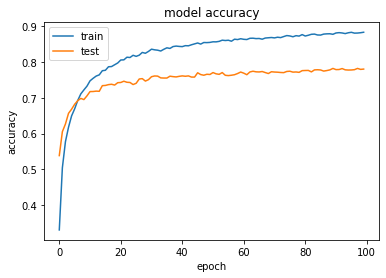

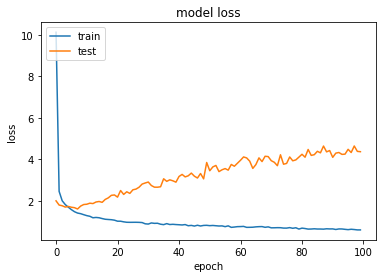

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

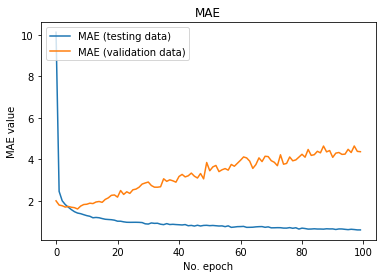

In [23]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

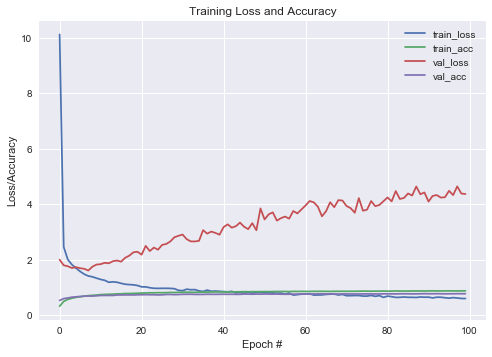

In [24]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2.png')
plt.close()